In [1]:
import os, math
from enum import StrEnum, auto
from collections import defaultdict, namedtuple, Counter, deque
import itertools
import sqlite3
import pickle
import datetime
import multiprocessing as mp
import gc
import json
import decimal
from IPython.core.getipython import get_ipython

from PIL import Image, ImageDraw
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import scipy
import numpy as np
import cupy as cp
import pandas as pd

from module.utils import *
from module.hdc import *
from module.constants import *

In [2]:
LOG = Logging()

config_var = 'SQLITE3_SEQ_GRID_0_2_4096'
config = Config(config_var)
RNG = np.random.default_rng()
mp_ctx = mp.get_context('spawn') # req-d for CUPY to work in multithreaded env, 'fork' method leads to failures in bootstrap somewhere around CUDA

if cp.cuda.is_available():
    xp = cp.get_array_module(cp.empty(1))
    xp_array_from_gpu = lambda a: a.get() if isinstance(a, cp.ndarray) else a
    xp_array_to_gpu = lambda a: cp.asarray(a) if isinstance(a, np.ndarray) else a
    xp_array_to_gpu_copy = lambda a: cp.asarray(a) if isinstance(a, np.ndarray) else a
else:
    xp = cp.get_array_module(np.empty(1))
    xp_array_from_gpu = lambda a: a
    xp_array_to_gpu = lambda a: a
    xp_array_to_gpu_copy = lambda a: a.copy()

print(f'xp = {xp.__name__}')

with open(get_ipython().kernel.config['IPKernelApp']['connection_file'], 'r') as cf:
    notebook_fname = json.load(cf)['jupyter_session']
    notebook_fname = os.path.basename(notebook_fname)

print(notebook_fname)

xp = numpy
transf_learn12.ipynb


In [3]:
%run sequencing_sp2.ipynb # req-d for sequences depickling

# Data Loading

In [4]:
%time
train_db_con = sqlite3.connect(DBUtils.get_full_db_file_name(config, config.train_db_file_name))
test_db_con = sqlite3.connect(DBUtils.get_full_db_file_name(config, config.test_db_file_name))

test_results_db_con = sqlite3.connect(DBUtils.get_full_db_file_name(config, config.test_results_db_file_name, with_prefix=False), autocommit=True)
test_results_db_con.execute('CREATE TABLE IF NOT EXISTS test_runs(test_run_id INTEGER PRIMARY KEY, dummy)')

transfs_db_con = sqlite3.connect(DBUtils.get_full_db_file_name(config, config.transfs_db_file_name, with_prefix=False), autocommit=True)
transfs_db_con.execute('CREATE TABLE IF NOT EXISTS features(encoding, type, x, y, radius, angle, bitmap_mask_nzb, nzb)')
transfs_db_con.execute('CREATE TABLE IF NOT EXISTS points(encoding, count, non_zero_bits, output_bit, nzb_list)')
transfs_db_con.execute('CREATE TABLE IF NOT EXISTS clusters(encoding, transf_code, output_bit, metas, nzb_list)');

CPU times: user 1 μs, sys: 0 ns, total: 1 μs
Wall time: 3.34 μs


In [5]:
# df_points = pd.read_sql('SELECT ROWID, points FROM points', con=transfs_db_con)

# for points_row in tqdm(df_points.itertuples(), total=len(df_points)):
#     row_id = int(points_row.rowid)
#     points = pickle.loads(points_row.points)
#     nzb_list = list(map(lambda p: np.flatnonzero(p), points))
#     transfs_db_con.execute('UPDATE points SET nzb_list=:nzb_list WHERE ROWID=:rowid', {'nzb_list': pickle.dumps(nzb_list), 'rowid': row_id})

In [6]:
# df_points = pd.read_sql('SELECT ROWID, nzb_list FROM points', con=transfs_db_con)

# for points_row in tqdm(df_points.itertuples(), total=len(df_points)):
#     row_id = int(points_row.rowid)
#     nzb_list = pickle.loads(points_row.nzb_list)
#     nzb_list = list(map(lambda nzb: list(map(int, nzb)), nzb_list))
#     transfs_db_con.execute('UPDATE points SET nzb_list=:nzb_list WHERE ROWID=:rowid', {'nzb_list': pickle.dumps(nzb_list), 'rowid': row_id})

In [7]:
# df_features = pd.read_sql('SELECT ROWID, sbv FROM features', con=transfs_db_con)

# for feature_row in tqdm(df_features.itertuples(), total=len(df_features)):
#     row_id = int(feature_row.rowid)
#     feature = pickle.loads(feature_row.sbv)
#     nzb = np.flatnonzero(feature)
#     transfs_db_con.execute('UPDATE features SET nzb=:nzb WHERE ROWID=:rowid', {'nzb': pickle.dumps(nzb), 'rowid': row_id})

In [8]:
# df_features = pd.read_sql('SELECT ROWID, nzb FROM features', con=transfs_db_con)

# for feature_row in tqdm(df_features.itertuples(), total=len(df_features)):
#     row_id = int(feature_row.rowid)
#     nzb = pickle.loads(feature_row.nzb)
#     nzb = list(map(int, nzb))
#     transfs_db_con.execute('UPDATE features SET nzb=:nzb WHERE ROWID=:rowid', {'nzb': pickle.dumps(nzb), 'rowid': row_id})

In [9]:
# df_features = pd.read_sql('SELECT ROWID, bitmap_mask_nzb FROM features', con=transfs_db_con)

# for feature_row in tqdm(df_features.itertuples(), total=len(df_features)):
#     row_id = int(feature_row.rowid)
#     bitmap_mask_nzb = pickle.loads(feature_row.bitmap_mask_nzb)
#     bitmap_mask_nzb = list(map(int, bitmap_mask_nzb))
#     transfs_db_con.execute('UPDATE features SET bitmap_mask_nzb=:bitmap_mask_nzb WHERE ROWID=:rowid', {'bitmap_mask_nzb': pickle.dumps(bitmap_mask_nzb), 'rowid': row_id})

In [10]:
# df_clusters = pd.read_sql('SELECT ROWID, sbv FROM clusters', con=transfs_db_con)

# for clusters_row in tqdm(df_clusters.itertuples(), total=len(df_clusters)):
#     row_id = int(clusters_row.rowid)
#     clusters = pickle.loads(clusters_row.sbv)
#     nzb_list = list(map(lambda c: np.flatnonzero(c), clusters))
#     transfs_db_con.execute('UPDATE clusters SET nzb_list=:nzb_list WHERE ROWID=:rowid', {'nzb_list': pickle.dumps(nzb_list), 'rowid': row_id})

In [11]:
# df_clusters = pd.read_sql('SELECT ROWID, nzb_list FROM clusters', con=transfs_db_con)

# for clusters_row in tqdm(df_clusters.itertuples(), total=len(df_clusters)):
#     row_id = int(clusters_row.rowid)
#     nzb_list = pickle.loads(clusters_row.nzb_list)
#     nzb_list = list(map(lambda nzb: list(map(int, nzb)), nzb_list))
#     transfs_db_con.execute('UPDATE clusters SET nzb_list=:nzb_list WHERE ROWID=:rowid', {'nzb_list': pickle.dumps(nzb_list), 'rowid': row_id})

In [12]:
df_train_images = pd.read_sql_query('SELECT * FROM images', con=train_db_con, index_col='image_id')
df_test_images = pd.read_sql_query('SELECT * FROM images', con=test_db_con, index_col='image_id')
df_train_images.shape, df_test_images.shape

((10000, 7), (2000, 7))


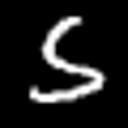
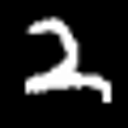
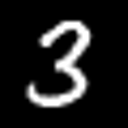
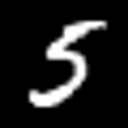
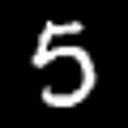
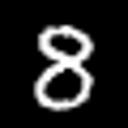
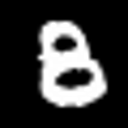
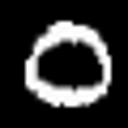
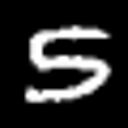
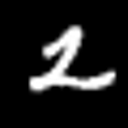
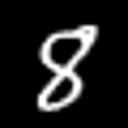
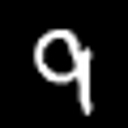
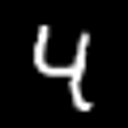
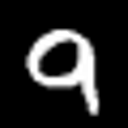
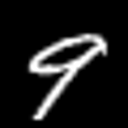
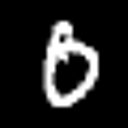

In [13]:
count = 8

def get_images_and_labels(df, ids):
    image_datas = df.loc[ids]['png']
    images = [Image.open(io.BytesIO(image_data)) for image_data in image_datas]
    labels = df.loc[ids]['value']
    return images, list(labels)

def get_some_random_images_and_labels(df, count):
    image_ids = RNG.choice(df.index.unique(), count, replace=False)
    return get_images_and_labels(df, image_ids)

train_images, train_labels = get_some_random_images_and_labels(df_train_images, count)
test_images, test_labels = get_some_random_images_and_labels(df_test_images, count)

display_images_grid(train_images + test_images, captions=train_labels + test_labels, col_count=count)

# Core logic

## Hyper Parameters

In [14]:
HP_SIGNAL_VEC_LEN = 1000 # aka SBV
HP_SIGNAL_VEC_NON_ZERO_BITS = 8
HP_SIGNAL_VEC_FEATURES_COUNT = 20
HP_SIGNAL_ENCODING = f'{HP_SIGNAL_VEC_LEN}/{HP_SIGNAL_VEC_NON_ZERO_BITS}'

HP_PIXEL_FEATURES_RANDOM_SEED = 42
HP_PIXEL_FEATURES_COUNT = 2_000

HP_POINTS_COUNT = 250_000
# HP_POINTS_COUNT = 100_000
HP_POINT_NON_ZERO_BITS = 40

## Types

In [15]:
class ClusterState(StrEnum):
    DEAD = auto()
    LEARN = auto()
    PROD_CANDIDATE = auto()
    PROD_WORK = auto()
    PROD_ETERNAL = auto()

class ClusterMeta:
    def __init__(self, cluster_ind):
        self.state = ClusterState.LEARN
        self.cluster_ind = cluster_ind
        self.cluster_key = ()
        self.output_bit = -1
        self.input_bits = ()
        self.ones_count = -1
        self.last_activity_cycle = 0 # TTL managemnet
        
        # props for LEARN state
        self.nu = 0
        self.signals_learned = -1
        self.signals_to_learn_till_binarization = 0
        self.binarization_schedule = ()
        
        # props for PROD_CANDIDATE/PROD_WORK states
        self.accuracy_calc = None
        self.verify_signal_ids = []

## Memory

In [16]:
def hdv_array_log_like_grow_policy(size):
    k = math.log(size, 100_000)
    new_size = size * 2 if k < 1 else size * 1.1
    return int(new_size)

def gc_memory():
    gc.collect()
    
    if cp.cuda.is_available():
        cp.get_default_memory_pool().free_all_blocks()

## Lambdas, Minifuncs, etc.

In [77]:
fetch_si_xy = lambda si: (si.x, si.y)
get_sequence = lambda sequences: np.array(list(itertools.chain.from_iterable(sequences)))
get_sequences_reading = lambda sequences, seq_reading_code: list(map(lambda r: sequences[r[0]] if r[1] == 0 else list(reversed(sequences[r[0]])), seq_reading_code))
get_xy_sequence = lambda sequence, si_ind_dict: np.array(list(map(lambda si_ind: fetch_si_xy(si_ind_dict[si_ind]), sequence)))
get_raw_image = lambda image_id: Image.open(io.BytesIO((df_train_images if image_id < 100_000_000 else df_test_images).loc[image_id]['png']))
get_cluster_key = lambda output_bit, input_bits: (int(output_bit), tuple(map(int, sorted(input_bits))))

bundle_sbvs = lambda sbvs: np.where(sbvs.sum(axis=0), 1, 0) # aka bloom filter
debundle_sbv = lambda sbv, sbv_dict_array, non_zero_bits: (sbv_dict_array @ sbv) == non_zero_bits

# NZV = non-zero bits, e.g. [2, 3, 8]
# SBV = sparsed binary vector, e.g. [0, 0, 1, 1, 0, 0, 0, 0, 1, 0]
def nzb_to_sbv(nzb, sbv_len):
    vec = np.zeros(sbv_len, dtype='f')
    vec[nzb] = 1
    return vec

sbv_to_nzb = lambda sbv: list(map(int, np.flatnonzero(sbv)))

# OHE = one-hot encoding
def xy_list_to_ohe_vec(xy_list):
    valid_boolmap = np.all(((xy_list >= 0) & (xy_list < config.sample_size)), axis=1)
    xy_list = xy_list[valid_boolmap]
    inds = xy_list @ np.array([1, config.sample_size])
    vec = np.zeros(config.sample_size ** 2, dtype='f')
    vec[inds] = 1
    return vec

## Average Filters

In [18]:
# https://youtu.be/HCd-leV8OkU?t=1240
class AverageFilter:
    def __init__(self):
        self.value = 0 # aka prev_average
        self.n = 0

    def __call__(self, x):
        self.n += 1
        alpha = (self.n - 1) / self.n
        result = alpha * self.value + (1 - alpha) * x
        self.value = result
        return result

In [19]:
a = 1 + np.arange(9)
f = AverageFilter()
avg = f(a[0])
assert np.isclose(avg, 1)
assert np.isclose(avg, f.value)

for x in a[1:]:
    avg = f(x)
    assert np.isclose(avg, f.value)

assert np.isclose(avg, 5)
assert np.isclose(avg, f.value)

In [20]:
# https://www.youtube.com/watch?v=HCd-leV8OkU&t=583s
# https://read.nxtbook.com/ieee/signal_processing/signal_processing_nov_2023/implementing_moving_average_f.html
class MovingAverageFilter:
    def __init__(self, n):
        assert n >= 1
        self.n = n
        self.prev_average = 0
        self.value = 0 
        self.x_queue = deque()

    def __call__(self, x):
        self.x_queue.append(x)

        while len(self.x_queue) > (self.n + 1):
            self.x_queue.popleft()

        x_old = self.x_queue[0] if len(self.x_queue) > self.n else 0
        result = self.prev_average + (x - x_old) / self.n
        self.prev_average = result

        if len(self.x_queue) < (self.n + 1):
            result = result * self.n / len(self.x_queue)

        self.value = result
        return result

In [21]:
a = np.array([55, 60, 19, 80, 30, 19, 57, 26, 36, 78, 70, 34,  5, 65, 22, 10, 53,
       28, 98,  1, 67, 94, 29, 37, 87, 98, 39, 71, 98, 68, 47, 20, 15, 13,
        3, 83, 43, 86, 95, 21,  3, 64, 20, 97, 47, 15, 78, 20, 80, 75, 31,
       11, 24, 54, 53, 42, 44,  8,  1, 74, 47, 63,  5, 34, 89, 72, 95, 17,
       69, 67, 57, 42,  2, 81, 67, 41, 14, 25, 74, 59, 78,  1, 75, 15,  7,
       70, 68, 36, 60, 46, 81,  2, 34, 39, 71, 42, 30, 48, 26, 86])
f = MovingAverageFilter(10)
avg = f(a[0])
assert np.isclose(avg, a[0])
assert np.isclose(avg, f.value)

for x in a[1:]:
    avg = f(x)
    assert np.isclose(avg, f.value)

assert np.isclose(avg, 45.9)
assert np.isclose(avg, f.value)

## Pixel Features

In [125]:
rng_for_pixel_features = np.random.default_rng(HP_PIXEL_FEATURES_RANDOM_SEED)

In [126]:
class PixelFeature:
    def __init__(self, x, y, radius, bitmap_mask, dist_mask):
        self.x = x
        self.y = y
        self.radius = radius
        self.bitmap_mask = bitmap_mask
        self.dist_mask = dist_mask
        self.sbv = None

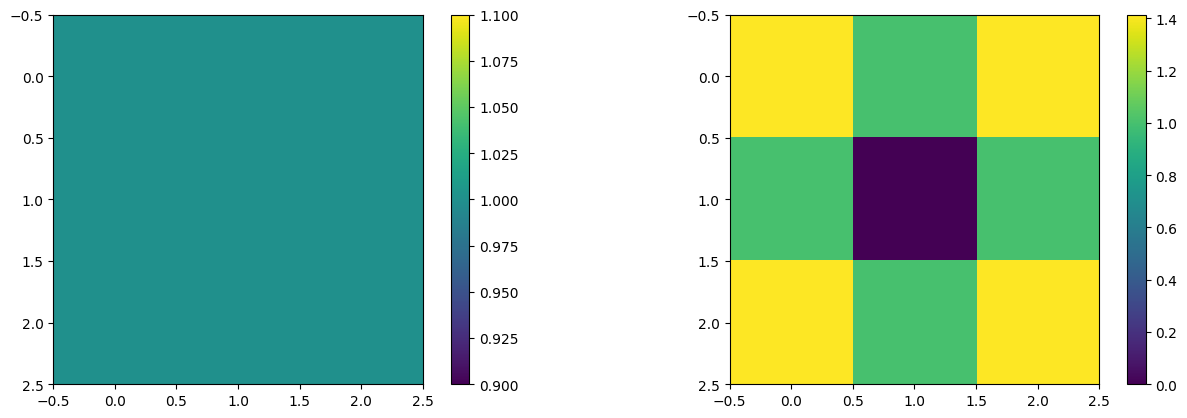

In [127]:
radius_to_pattern = {}
radius_to_dist_pattern = {} # config.sample_size if pixel if out of pattern, otherwise distance to center (within center distance = 0)

# for r in [3, 1]:
# for r in [5]:
# for r in [3]:
# for r in [2]:
for r in [1]:
    if r == 1:
        canvas = Image.new('1', size=(r * 2 + 1, r * 2 + 1), color='white')
    else:
        canvas = Image.new('1', size=(r * 2 + 1, r * 2 + 1), color='black')
        draw = ImageDraw.Draw(canvas)
        draw.circle([r, r], radius=r, outline='white', fill='white')

    pattern = np.array(canvas, dtype='f')
    radius_to_pattern[r] = pattern

    dist_pattern = np.zeros_like(pattern, dtype='f')
    
    for i in range(pattern.shape[0]):
        for j in range(pattern.shape[1]):
            dist = config.sample_size
            
            if pattern[i,j] != 0:
                vec = np.array([i - r, j - r])
                dist = np.linalg.norm(vec)
                assert dist < config.sample_size

            dist_pattern[i,j] = dist
    
    radius_to_dist_pattern[r] = dist_pattern

r = max(radius_to_pattern.keys())

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(16)
im = ax1.imshow(radius_to_pattern[r])
fig.colorbar(im, ax=ax1);
im = ax2.imshow(np.where(radius_to_dist_pattern[r] < config.sample_size, radius_to_dist_pattern[r], np.inf))
fig.colorbar(im, ax=ax2);

In [128]:
# n = 50_000
# xs = rng_for_pixel_features.integers(0, config.sample_size, size=n)
# ys = rng_for_pixel_features.integers(0, config.sample_size, size=n)
# radii = rng_for_pixel_features.choice(list(radius_to_pattern.keys()), size=n)
# xy_list = np.vstack([xs, ys]).T
# assert np.all(np.all((xy_list >= 0) & (xy_list < config.sample_size), axis=1))
# bitmap_padding = 0
# bitmap = np.zeros((config.sample_size + bitmap_padding * 2, config.sample_size + bitmap_padding * 2))
# pixel_features = []

# for xy, radius in zip(xy_list, radii):
#     pattern = radius_to_pattern[radius]
#     i0, j0 = bitmap_padding, bitmap_padding
#     i = i0 + xy[1]
#     j = j0 + xy[0]
#     i_lo = i - radius
#     i_hi = i + radius + 1
#     j_lo = j - radius
#     j_hi = j + radius + 1
    
#     if i_lo < 0 or j_lo < 0 or i_hi > config.sample_size or j_hi > config.sample_size:
#         continue
    
#     merge_site = bitmap[i_lo:i_hi,j_lo:j_hi]
#     merge_site_mask = np.where(merge_site != 0, 1, 0)
#     assert pattern.shape == merge_site.shape
#     overlap_ratio = np.where(pattern != 0, merge_site_mask, 0).sum() / pattern.sum()

#     # if overlap_ratio > 0.75:
#     # if overlap_ratio > 0.5:
#     # if overlap_ratio > 0.35:
#     if overlap_ratio > 0.25:
#     # if overlap_ratio > 0.0:
#         continue
    
#     # merge_site = np.where(pattern != 0, radius, merge_site)
#     merge_site = merge_site + pattern
#     bitmap[i-radius:i+radius+1,j-radius:j+radius+1] = merge_site
#     pixel_feature_bitmap_mask = np.zeros_like(bitmap, dtype='f')
#     pixel_feature_bitmap_mask[i_lo:i_hi,j_lo:j_hi] = pattern
#     pixel_feature_bitmap_mask = pixel_feature_bitmap_mask[bitmap_padding:bitmap_padding+config.sample_size, bitmap_padding:bitmap_padding+config.sample_size]
#     pixel_feature_dist_mask = np.full_like(bitmap, config.sample_size, dtype='f')
#     pixel_feature_dist_mask[i_lo:i_hi,j_lo:j_hi] = radius_to_dist_pattern[radius]
#     pixel_feature = PixelFeature(x=int(xy[0]), y=int(xy[1]), radius=radius, bitmap_mask=pixel_feature_bitmap_mask.ravel(), dist_mask=pixel_feature_dist_mask.ravel())
#     pixel_features.append(pixel_feature)

#     if len(pixel_features) >= HP_PIXEL_FEATURES_COUNT:
#         break
    
# bitmap = bitmap[bitmap_padding:bitmap_padding+config.sample_size, bitmap_padding:bitmap_padding+config.sample_size]

# fig, (ax1, ax2) = plt.subplots(1, 2)
# fig.set_figwidth(18)

# ax1.set_title(f'Pixel-Features Count={len(pixel_features)}, non-covered area={(bitmap == 0).sum() / (bitmap.shape[0] ** 2) * 100:.1f}%')
# im = ax1.imshow(bitmap, cmap='turbo')
# fig.colorbar(im, ax=ax1);

# random_pixel_feature_ind = rng_for_pixel_features.choice(len(pixel_features))
# ax2.set_title(f'Bitmap Mask of Pixel-Feature #{random_pixel_feature_ind}')
# im = ax2.imshow(vec_to_square_matrix(pixel_features[random_pixel_feature_ind].bitmap_mask), cmap='bwr')

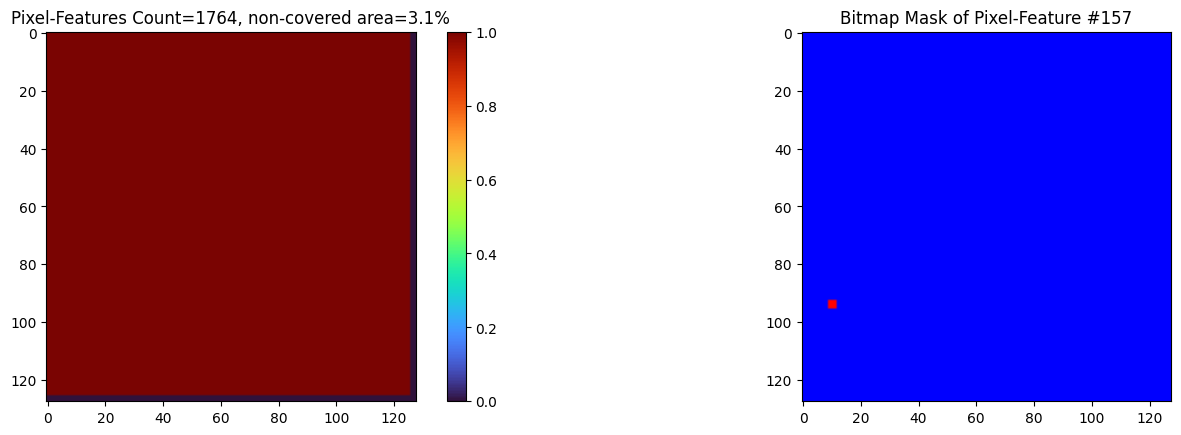

In [129]:
radius = max(radius_to_pattern.keys())

mgrid = np.mgrid[0:config.sample_size, 0:config.sample_size]
xs = mgrid[0].ravel()
ys = mgrid[1].ravel()
xy_list = np.vstack([xs, ys]).T
assert np.all(np.all((xy_list >= 0) & (xy_list < config.sample_size), axis=1))

bitmap_padding = 0
bitmap = np.zeros((config.sample_size + bitmap_padding * 2, config.sample_size + bitmap_padding * 2))
pixel_features = []

# for overlap in [0, 0.25, 0.5]:
for overlap in [0]:
    for xy in xy_list:
        if len(pixel_features) >= HP_PIXEL_FEATURES_COUNT:
            break
            
        if bitmap[xy[1], xy[0]] != 0:
            continue

        pattern = radius_to_pattern[radius]
        i0, j0 = bitmap_padding, bitmap_padding
        i = i0 + xy[1]
        j = j0 + xy[0]
        i_lo = i - radius
        i_hi = i + radius + 1
        j_lo = j - radius
        j_hi = j + radius + 1
        
        if i_lo < 0 or j_lo < 0 or i_hi > config.sample_size or j_hi > config.sample_size:
            continue
        
        merge_site = bitmap[i_lo:i_hi,j_lo:j_hi]
        merge_site_mask = np.where(merge_site != 0, 1, 0)
        assert pattern.shape == merge_site.shape
        overlap_ratio = np.where(pattern != 0, merge_site_mask, 0).sum() / pattern.sum()
    
        if overlap_ratio > overlap:
            continue
        
        merge_site = merge_site + pattern
        bitmap[i-radius:i+radius+1,j-radius:j+radius+1] = merge_site
        pixel_feature_bitmap_mask = np.zeros_like(bitmap, dtype='f')
        pixel_feature_bitmap_mask[i_lo:i_hi,j_lo:j_hi] = pattern
        pixel_feature_bitmap_mask = pixel_feature_bitmap_mask[bitmap_padding:bitmap_padding+config.sample_size, bitmap_padding:bitmap_padding+config.sample_size]
        pixel_feature_dist_mask = np.full_like(bitmap, config.sample_size, dtype='f')
        pixel_feature_dist_mask[i_lo:i_hi,j_lo:j_hi] = radius_to_dist_pattern[radius]
        pixel_feature = PixelFeature(x=int(xy[0]), y=int(xy[1]), radius=radius, bitmap_mask=pixel_feature_bitmap_mask.ravel(), dist_mask=pixel_feature_dist_mask.ravel())
        pixel_features.append(pixel_feature)
    
bitmap = bitmap[bitmap_padding:bitmap_padding+config.sample_size, bitmap_padding:bitmap_padding+config.sample_size]

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(18)

ax1.set_title(f'Pixel-Features Count={len(pixel_features)}, non-covered area={(bitmap == 0).sum() / (bitmap.shape[0] ** 2) * 100:.1f}%')
im = ax1.imshow(bitmap, cmap='turbo')
fig.colorbar(im, ax=ax1);

random_pixel_feature_ind = rng_for_pixel_features.choice(len(pixel_features))
ax2.set_title(f'Bitmap Mask of Pixel-Feature #{random_pixel_feature_ind}')
im = ax2.imshow(vec_to_square_matrix(pixel_features[random_pixel_feature_ind].bitmap_mask), cmap='bwr')

In [174]:
df_pixel_features = pd.read_sql('SELECT x, y, radius, nzb FROM features WHERE encoding=:encoding AND type=:type', 
                                params={'encoding': HP_SIGNAL_ENCODING, 'type': 'pixel'}, con=transfs_db_con)
db_pixel_features_dict = dict(map(lambda p: ((p.x, p.y, p.radius), nzb_to_sbv(pickle.loads(p.nzb), HP_SIGNAL_VEC_LEN)), df_pixel_features.itertuples()))
unique_sbv_keys = set(map(lambda sbv: tuple(sorted(map(int, np.flatnonzero(sbv)))), db_pixel_features_dict.values()))
assert len(unique_sbv_keys) == len(db_pixel_features_dict)
print(f'Loaded {len(unique_sbv_keys)} pixel features')
new_pixel_features = []
linked_count = 0

for pf in pixel_features:
    key = (pf.x, pf.y, pf.radius)

    if key in db_pixel_features_dict:
        pf.sbv = db_pixel_features_dict[key]
        linked_count += 1
        continue
        
    attempts_to_generate_unique_sbv = 10
    sbv = np.zeros(HP_SIGNAL_VEC_LEN, dtype='f')

    for _ in range(attempts_to_generate_unique_sbv):
        ii = RNG.choice(HP_SIGNAL_VEC_LEN, HP_SIGNAL_VEC_NON_ZERO_BITS, replace=False)
        sbv_key = tuple(sorted(ii))

        if not sbv_key in unique_sbv_keys:
            sbv[ii] = 1
            unique_sbv_keys.add(sbv_key)
            break
    else:
        assert False, f'Failed to get unique SBV for pixel feature within {attempts_to_generate_unique_sbv} attempts'

    new_pixel_features.append(pf)
    pf.sbv = sbv

print(f'Linked {linked_count} pixel features')

if new_pixel_features:
    transfs_db_con.autocommit = False
    
    for pf in tqdm(new_pixel_features, desc='Persiting'):
        transfs_db_con.execute('INSERT INTO features(encoding, type, x, y, radius, bitmap_mask_nzb, nzb) VALUES (:encoding, :type, :x, :y, :radius, :bitmap_mask_nzb, :nzb)',
                               {
                                   'encoding': HP_SIGNAL_ENCODING, 
                                   'type': 'pixel', 
                                   'x': pf.x, 
                                   'y': pf.y, 
                                   'radius': pf.radius, 
                                   'bitmap_mask_nzb': pickle.dumps(sbv_to_nzb(pf.bitmap_mask)),
                                   'nzb': pickle.dumps(sbv_to_nzb(pf.sbv))
                               })

    transfs_db_con.autocommit = True
    print(f'Created and persisted {len(new_pixel_features)} new pixel features')

PIXEL_FEATURE_SBVS = np.array(list(map(lambda pf: pf.sbv, pixel_features)))
PIXEL_FEATURE_BITMAP_MASKS = xp.array(list(map(lambda pf: pf.bitmap_mask, pixel_features)))
PIXEL_FEATURE_DIST_MASKS = xp.array(list(map(lambda pf: pf.dist_mask, pixel_features)))
PIXEL_FEATURE_XY_ARRAY = np.array(list(map(lambda pf: (pf.x, pf.y), pixel_features)))

Loaded 2869 pixel features
Linked 1764 pixel features


In [78]:
df_train_images_ = df_train_images.head(2000)
# df_train_images_ = df_train_images
PIXEL_FEATURE_FREQS = np.zeros(PIXEL_FEATURE_SBVS.shape[0], dtype='i')

for image in tqdm(df_train_images_.itertuples(), total=len(df_train_images_)):
    sequences = pickle.loads(image.inner_sequences)
    si_ind_dict = pickle.loads(image.inner_si_ind_dict)
    xy_list_full = get_xy_sequence(get_sequence(sequences), si_ind_dict)
    ohe_vec = xy_list_to_ohe_vec(xy_list_full)
    pixel_feature_inds = np.flatnonzero(PIXEL_FEATURE_BITMAP_MASKS @ ohe_vec)
    PIXEL_FEATURE_FREQS[pixel_feature_inds] += 1

  0%|          | 0/2000 [00:00<?, ?it/s]

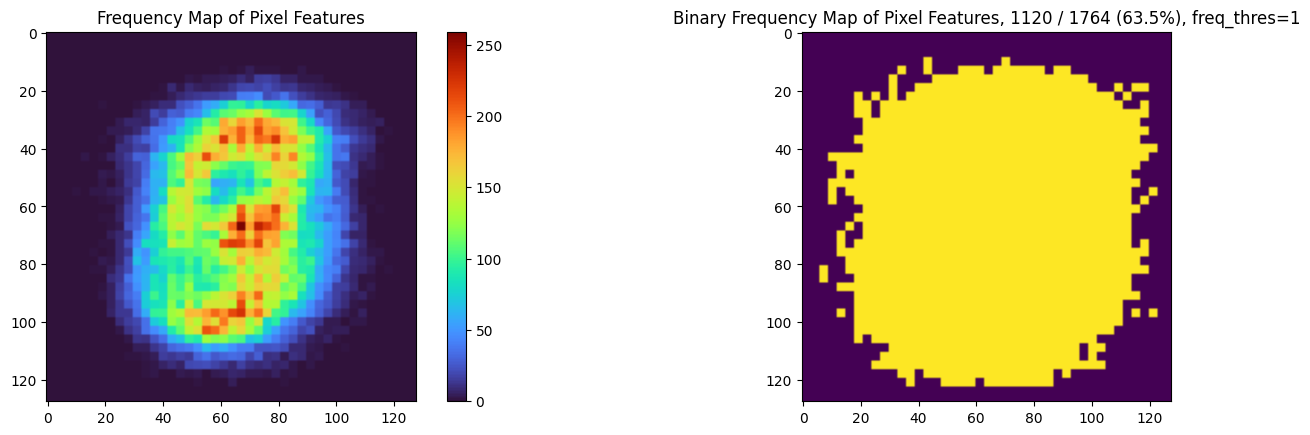

In [79]:
bitmap = np.zeros((config.sample_size, config.sample_size), dtype='i')
assert PIXEL_FEATURE_BITMAP_MASKS.shape[0] == PIXEL_FEATURE_FREQS.shape[0]

for mask, freq in zip(PIXEL_FEATURE_BITMAP_MASKS, PIXEL_FEATURE_FREQS):
    mask_with_freq = np.where(mask, freq, 0)
    bitmap += mask_with_freq.reshape(bitmap.shape)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(18)

ax1.set_title(f'Frequency Map of Pixel Features')
im = ax1.imshow(bitmap, cmap='turbo')
fig.colorbar(im, ax=ax1)

pixel_feature_freqs_sorted_desc = -np.sort(-PIXEL_FEATURE_FREQS)
percentile = 1
ind = int(np.count_nonzero(pixel_feature_freqs_sorted_desc) * percentile)
freq_thres = pixel_feature_freqs_sorted_desc[ind-1]
# bitmap2 = np.where(bitmap, 1, 0)
bitmap2 = np.where(PIXEL_FEATURE_BITMAP_MASKS[(PIXEL_FEATURE_FREQS >= freq_thres)].sum(axis=0), 1, 0)
bitmap2 = vec_to_square_matrix(bitmap2)
# a = (PIXEL_FEATURE_FREQS > 0).sum()
a = (PIXEL_FEATURE_FREQS >= freq_thres).sum()
b = PIXEL_FEATURE_BITMAP_MASKS.shape[0]
ax2.set_title(f'Binary Frequency Map of Pixel Features, {a} / {b} ({a / b * 100:.1f}%), freq_thres={freq_thres}')
ax2.imshow(bitmap2);

## Transformations

In [80]:
def get_rotate_transf(deg):
    half_sz = config.sample_size / 2
    move_to_ooc_transf = np.array([
        [1, 0, -half_sz],
        [0, 1, -half_sz],
        [0, 0, 1]])
    theta = np.deg2rad(deg)
    cos_theta = math.cos(theta)
    sin_theta = math.sin(theta)
    rotate_transf = np.array([
        [cos_theta, -sin_theta, 0],
        [sin_theta, cos_theta, 0],
        [0, 0, 1]
    ])
    move_to_target_loc_transf = np.array([
        [1, 0, half_sz],
        [0, 1, half_sz],
        [0, 0, 1]])
    return move_to_target_loc_transf @ rotate_transf @ move_to_ooc_transf

def get_offset_transf(dx=0, dy=0):
    return np.array([
        [1, 0, dx],
        [0, 1, dy],
        [0, 0, 1]])

In [81]:
transfs = {
    'offset_10_0': get_offset_transf(10, 0),
    'offset_1_0': get_offset_transf(1, 0),
    'offset_-1_0': get_offset_transf(-1, 0),
    'offset_0_1': get_offset_transf(0, 1),
    'offset_1_1': get_offset_transf(1, 1),
    'offset_5_0': get_offset_transf(5, 0),
    'rotate_45': get_rotate_transf(45),
    'rotate_90': get_rotate_transf(90),
}
TRANSF_CODE = 'rotate_45'
TRANSF = transfs[TRANSF_CODE]

## XY List <-> Pixel Features

In [82]:
def xy_list_to_pixel_feature_inds(xy_list):
    ohe_vec = xy_list_to_ohe_vec(xy_list)
    return np.flatnonzero(PIXEL_FEATURE_BITMAP_MASKS @ ohe_vec)

def xy_list_to_nearest_pixel_feature_inds(xy_list):
    valid_boolmap = np.all(((xy_list >= 0) & (xy_list < config.sample_size)), axis=1)
    xy_list = xy_list[valid_boolmap]
    inds = xy_list @ np.array([1, config.sample_size])
    vecs = np.zeros((inds.shape[0], config.sample_size ** 2), dtype='f')

    for i, j in enumerate(inds):
        vecs[i,j] = 1

    # compute matrix where rows correspond to xy pairs and columns correspond to pixel features
    # value in cell [i,j] == dist_from_xy[i]_to_center_of_pixel_feature[j]
    mat = vecs @ PIXEL_FEATURE_DIST_MASKS.T
    # for each xy get index of pixel feature which has minimal distance to center of pixel feature
    t = np.argmin(mat, axis=1)
    # if row consists of dists which exceed config.sample_size then np.argmin has no sense for such row (it means that there is no match with any pixel feature),
    # as such - exclude such row from consideration
    rows_with_good_values_boolmap = np.any(mat < config.sample_size, axis=1)
    t = t[rows_with_good_values_boolmap]
    return np.unique(t)

## Signals Generator

In [83]:
SignalsGeneratorResult = namedtuple('SignalsGeneratorResult', ['signals_input', 'signals_output', 'signal_ids', 'signal_xy_lists_input', 'signal_xy_lists_output', 'xy_list_full'])

def get_signals_generator(transf, signals_count, image_variants_count):
    context = {}
    
    def generate():
        signals_input = []
        signals_output = []
        signal_ids = []
        signal_xy_lists_input = []
        signal_xy_lists_output = []

        while len(signals_input) < signals_count:
            if not context or context['image_variants_generated'] >= context['image_variants_count']:
                # the very first call or variants of current image are exhausted, switch to next image
                context['image_id'] = int(RNG.choice(df_train_images.index))
                context['image_variants_generated'] = 0
                image = df_train_images.loc[context['image_id']]
                # pickle.loads consumes almost 50% of the time of execution of generate() :=(
                sequences = pickle.loads(image.inner_sequences)
                si_ind_dict = pickle.loads(image.inner_si_ind_dict)
                xy_list_full = get_xy_sequence(get_sequence(sequences), si_ind_dict)
                context['xy_list_full'] = xy_list_full
                
                xy_list_inds_count = min(xy_list_full.shape[0], HP_SIGNAL_VEC_FEATURES_COUNT)
                xy_list_combinations_count = math.comb(xy_list_full.shape[0], xy_list_inds_count)

                if xy_list_combinations_count >= image_variants_count:
                    context['xy_list_inds_count'] = xy_list_inds_count
                    context['image_variants_count'] = image_variants_count
                else:
                    assert xy_list_inds_count > 0
                    xy_list_inds_count_to_combinations_count = Counter()
                
                    for inds_count in range(xy_list_inds_count, 0, -1):
                        xy_list_inds_count_to_combinations_count[inds_count] = math.comb(xy_list_full.shape[0], inds_count)

                    xy_list_inds_count_with_most_variants = xy_list_inds_count_to_combinations_count.most_common(1)[0]
                    context['xy_list_inds_count'] = xy_list_inds_count_with_most_variants[0]
                    context['image_variants_count'] = min(image_variants_count, xy_list_inds_count_with_most_variants[1])
            
                assert context['xy_list_inds_count'] > 0
                assert context['xy_list_inds_count'] <= context['xy_list_full'].shape[0]
                assert context['image_variants_count'] > 0 and context['image_variants_count'] <= image_variants_count, context['image_variants_count']

            xy_list_inds = RNG.choice(context['xy_list_full'].shape[0], context['xy_list_inds_count'], replace=False)
            xy_list_origin = context['xy_list_full'][xy_list_inds]
            xy_list_transf = np.hstack([xy_list_origin, np.ones(xy_list_origin.shape[0])[:,np.newaxis]]) # make homogeneous coords
            xy_list_transf = (transf @ xy_list_transf.T).T[:,:2]
            xy_list_transf = np.round(xy_list_transf, decimals=0).astype(int)
            xy_list_origin_sbv = bundle_sbvs(PIXEL_FEATURE_SBVS[xy_list_to_pixel_feature_inds(xy_list_origin)])
            xy_list_transf_sbv = bundle_sbvs(PIXEL_FEATURE_SBVS[xy_list_to_pixel_feature_inds(xy_list_transf)])
            assert xy_list_origin_sbv.shape[0] == HP_SIGNAL_VEC_LEN
            assert xy_list_transf_sbv.shape[0] == HP_SIGNAL_VEC_LEN
            
            context['image_variants_generated'] += 1
            signals_input.append(xy_list_origin_sbv)
            signals_output.append(xy_list_transf_sbv)
            signal_ids.append((context['image_id'], tuple(map(int, sorted(xy_list_inds)))))
            signal_xy_lists_input.append(xy_list_origin)
            signal_xy_lists_output.append(xy_list_transf)

        assert len(signals_input) == len(signals_output)
        assert len(signals_input) == len(signal_ids)
        assert len(signals_input) == len(signal_xy_lists_input)
        assert len(signals_input) == len(signal_xy_lists_output)
        return SignalsGeneratorResult(signals_input=signals_input, 
                                      signals_output=signals_output, 
                                      signal_ids=signal_ids,
                                      signal_xy_lists_input=signal_xy_lists_input,
                                      signal_xy_lists_output=signal_xy_lists_output,
                                      xy_list_full=context['xy_list_full'])
                
    return generate

In [133]:
# one pixel feature is fixed for a number calls (fixation period) and remaining features are randomly picked according to their frequency
class FixedPixelFeatureSignalsGenerator:
    def __init__(self, transf, signals_count, fixation_period):
        self.transf = transf
        self.signals_count = signals_count
        assert fixation_period > 0
        self.fixation_period = fixation_period
        self.fixation_countdown = self.fixation_period
        self.fixed_pixel_feature_ind = -1
        self.pixel_feature_inds_sorted_by_freq_desc = np.argsort(-PIXEL_FEATURE_FREQS)
        # strip pixel feature which have zero freqs, i.o.w. leave only those with nonzero
        self.pixel_feature_inds_sorted_by_freq_desc = self.pixel_feature_inds_sorted_by_freq_desc[:np.count_nonzero(self.pixel_feature_inds_sorted_by_freq_desc)]
        assert self.pixel_feature_inds_sorted_by_freq_desc.shape[0] > 0
        self.pixel_feature_inds = np.arange(PIXEL_FEATURE_SBVS.shape[0])
        
    def __call__(self):
        signals_input = [] # SBV
        signals_output = [] # SBV
        signal_ids = []
        signal_xy_lists_input = []
        signal_xy_lists_output = []

        while len(signals_input) < self.signals_count:
            if self.fixed_pixel_feature_ind == -1 or self.fixation_countdown <= 0:
                self.fixed_pixel_feature_ind = self.pixel_feature_inds_sorted_by_freq_desc[0]
                self.pixel_feature_inds_sorted_by_freq_desc = np.roll(self.pixel_feature_inds_sorted_by_freq_desc, -1)
                # temporarily ban fixed pixel feature from beeing picked up as a free one
                self.free_pixel_feature_probs = PIXEL_FEATURE_FREQS[:].astype('f')
                self.free_pixel_feature_probs[self.fixed_pixel_feature_ind] = 0
                self.free_pixel_feature_probs /= self.free_pixel_feature_probs.sum()

            assert self.fixed_pixel_feature_ind != -1
            # pick up remaining pixel feature (via their probabilities) excluding fixed pixel feature
            free_pixel_feature_inds = RNG.choice(self.pixel_feature_inds, HP_SIGNAL_VEC_FEATURES_COUNT - 1, p=self.free_pixel_feature_probs, replace=False)
            pixel_feature_inds_input = np.hstack([self.fixed_pixel_feature_ind, free_pixel_feature_inds])
            xy_list_input = PIXEL_FEATURE_XY_ARRAY[pixel_feature_inds_input]
            xy_list_transf = np.hstack([xy_list_input, np.ones(xy_list_input.shape[0])[:,np.newaxis]]) # make homogeneous coords
            xy_list_transf = (self.transf @ xy_list_transf.T).T[:,:2]
            xy_list_transf = np.round(xy_list_transf, decimals=0).astype(int)
            # pixel_feature_inds_output = xy_list_to_nearest_pixel_feature_inds(xy_list_transf) # must be used when there is overlap between pixel features
            pixel_feature_inds_output = xy_list_to_pixel_feature_inds(xy_list_transf) # can be used when there is overlap between pixel features
            xy_list_output = PIXEL_FEATURE_XY_ARRAY[pixel_feature_inds_output]
            xy_list_input_sbv = bundle_sbvs(PIXEL_FEATURE_SBVS[pixel_feature_inds_input])
            xy_list_output_sbv = bundle_sbvs(PIXEL_FEATURE_SBVS[pixel_feature_inds_output])
            assert xy_list_input_sbv.shape[0] == HP_SIGNAL_VEC_LEN
            assert xy_list_output_sbv.shape[0] == HP_SIGNAL_VEC_LEN
            
            signals_input.append(xy_list_input_sbv)
            signals_output.append(xy_list_output_sbv)
            signal_ids.append(tuple(map(int, sorted(pixel_feature_inds_input))))
            signal_xy_lists_input.append(xy_list_input)
            signal_xy_lists_output.append(xy_list_output)

            self.fixation_countdown -= 1

        assert len(signals_input) == len(signals_output)
        assert len(signals_input) == len(signal_ids)
        assert len(signals_input) == len(signal_xy_lists_input)
        assert len(signals_input) == len(signal_xy_lists_output)
        return SignalsGeneratorResult(signals_input=signals_input,
                                      signals_output=signals_output,
                                      signal_ids=signal_ids,
                                      signal_xy_lists_input=signal_xy_lists_input,
                                      signal_xy_lists_output=signal_xy_lists_output,
                                      xy_list_full=[])

In [159]:
%%time
generator = FixedPixelFeatureSignalsGenerator(TRANSF, 100, 10)
sgr = generator()

CPU times: user 8.34 s, sys: 4.78 ms, total: 8.34 s
Wall time: 730 ms


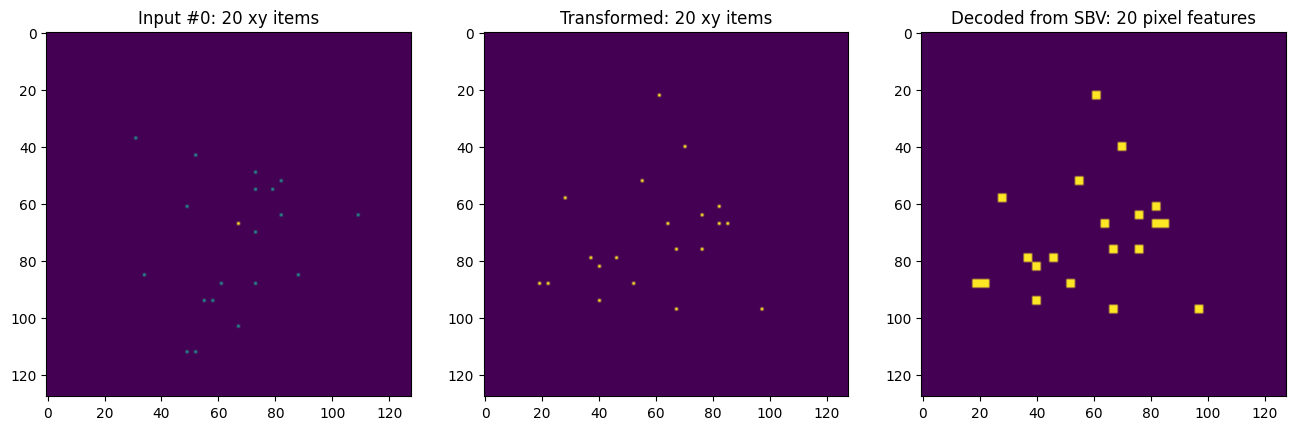

In [141]:
signal_ind = RNG.choice(len(sgr.signals_output))
# signal_ind = 19
pixel_feature_inds = debundle_sbv(sgr.signals_output[signal_ind], PIXEL_FEATURE_SBVS, HP_SIGNAL_VEC_NON_ZERO_BITS)
bm_output = PIXEL_FEATURE_BITMAP_MASKS[pixel_feature_inds].sum(axis=0)
    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figwidth(16)
ax1.set_title(f'Input #{signal_ind}: {sgr.signal_xy_lists_input[signal_ind].shape[0]} xy items')
t = xy_list_to_ohe_vec(sgr.signal_xy_lists_input[signal_ind])
t[PIXEL_FEATURE_XY_ARRAY[generator.fixed_pixel_feature_ind] @ [1, config.sample_size]] = 2
ax1.imshow(vec_to_square_matrix(t))
ax2.set_title(f'Transformed: {sgr.signal_xy_lists_output[signal_ind].shape[0]} xy items')
ax2.imshow(vec_to_square_matrix(xy_list_to_ohe_vec(sgr.signal_xy_lists_output[signal_ind])))
ax3.set_title(f'Decoded from SBV: {np.count_nonzero(pixel_feature_inds)} pixel features')
ax3.imshow(vec_to_square_matrix(bm_output));

## Points

In [22]:
df_points = pd.read_sql('SELECT output_bit, nzb_list FROM points WHERE encoding=:encoding AND count=:count AND non_zero_bits=:non_zero_bits', 
                        params={
                            'encoding': HP_SIGNAL_ENCODING,
                            'count': HP_POINTS_COUNT,
                            'non_zero_bits': HP_POINT_NON_ZERO_BITS}, 
                        con=transfs_db_con)

if len(df_points) > 0:
    POINTS = []
    POINT_OUTPUT_BITS = []
    
    for row in tqdm(df_points.itertuples(), total=len(df_points), desc='Load'):
        nzb_list = pickle.loads(row.nzb_list)
        l = len(nzb_list)
        assert l > 0
        points = np.zeros((l, HP_SIGNAL_VEC_LEN), dtype='f')

        for i, nzb in enumerate(nzb_list):
            points[i,nzb] = 1

        POINTS.append(points)
        
        point_output_bits = np.full(l, row.output_bit, dtype='i')
        POINT_OUTPUT_BITS.append(point_output_bits)
        
    POINTS = np.vstack(POINTS)
    POINT_OUTPUT_BITS = np.hstack(POINT_OUTPUT_BITS)
    assert np.all(POINTS.sum(axis=1) == HP_POINT_NON_ZERO_BITS)
    assert POINTS.shape[0] == POINT_OUTPUT_BITS.shape[0]
    assert POINTS.ndim == 2
    assert POINT_OUTPUT_BITS.ndim == 1
    print(f'{POINTS.shape[0]:_} POINTS loaded from database')
else:
    POINTS = []
    POINT_OUTPUT_BITS = []
    output_bits = RNG.choice(HP_SIGNAL_VEC_LEN, HP_POINTS_COUNT)
    output_bit_to_nzb_list = defaultdict(list)
    
    for output_bit in tqdm(output_bits, desc='Generate'):
        nzb = sbv_to_nzb(RNG.choice(HP_SIGNAL_VEC_LEN, HP_POINT_NON_ZERO_BITS, replace=False))
        
        point_vec = np.zeros(HP_SIGNAL_VEC_LEN, dtype='f')
        point_vec[nzb] = 1
        POINTS.append(point_vec)
        POINT_OUTPUT_BITS.append(output_bit)

        output_bit_to_nzb_list[output_bit].append(nzb)

    POINTS = np.vstack(POINTS)
    POINT_OUTPUT_BITS = np.hstack(POINT_OUTPUT_BITS)
    assert np.all(POINTS.sum(axis=1) == HP_POINT_NON_ZERO_BITS)
    assert POINTS.shape[0] == POINT_OUTPUT_BITS.shape[0]

    for output_bit, nzb_list in tqdm(output_bit_to_nzb_list.items(), desc='Save'):
        params = {
            'encoding': HP_SIGNAL_ENCODING, 
            'count': HP_POINTS_COUNT,
            'non_zero_bits': HP_POINT_NON_ZERO_BITS,
            'output_bit': int(output_bit),
            'nzb_list': pickle.dumps(nzb_list),
            }
        transfs_db_con.execute('INSERT INTO points(encoding, count, non_zero_bits, output_bit, nzb_list) ' + 
                               'VALUES(:encoding, :count, :non_zero_bits, :output_bit, :nzb_list)', params)
    
    print(f'{POINTS.shape[0]:_} POINTS created from scratch')

Load:   0%|          | 0/1000 [00:00<?, ?it/s]

250_000 POINTS loaded from database


## .lab hdc

In [30]:
# hdc = Hdc(10_000, np, dtype='f')
# hdc.bundle = hdc.bundle_noties
# hdc.cos_sim_threshold = 0.055
# hdc.hdist_threshold = 4700

hdc = Hdc(1_000, np, dtype='f')
hdc.bundle = hdc.bundle_noties
hdc.cos_sim_threshold = 0.10

# hdc = Hdc(2_000, np, dtype='f')
# hdc.bundle = hdc.bundle_noties
# hdc.cos_sim_threshold = 0.10

In [31]:
PIXEL_HDVS = hdc(config.sample_size ** 2)
PIXEL_HDVS_NORM = hdc.normalize(PIXEL_HDVS)

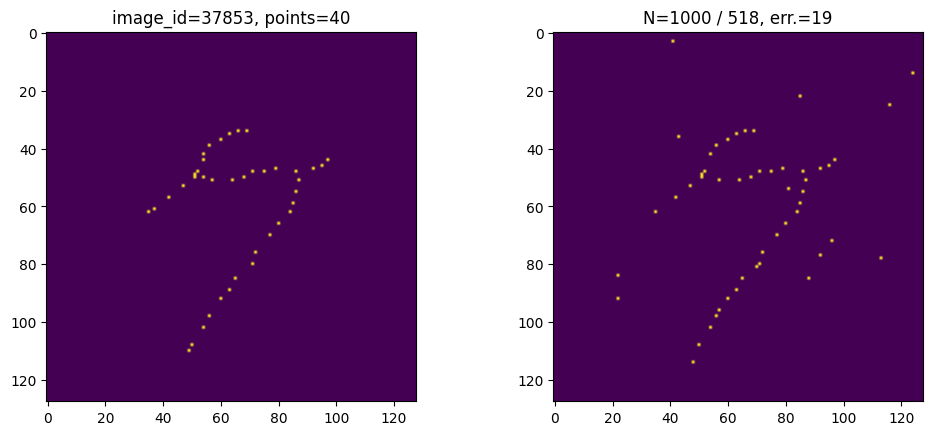

In [32]:
image_id = RNG.choice(df_train_images.index)
image = next(df_train_images.loc[[image_id]].itertuples())
si_ind_dict = pickle.loads(image.inner_si_ind_dict)
sequences = pickle.loads(image.inner_sequences)
seq = get_sequence(sequences)
seq_xy = get_xy_sequence(seq, si_ind_dict)
ii = np.all(((seq_xy >= 0) & (seq_xy < config.sample_size)), axis=1) 
seq_xy = seq_xy[ii]
ind_seq = (seq_xy @ np.array([1, config.sample_size])).astype(int)
seq_bv_true = np.zeros((config.sample_size, config.sample_size)).ravel()
seq_bv_true[ind_seq] = 1

seq_hdv = hdc.bundle(PIXEL_HDVS[ind_seq])
seq_hdv_binary = hdc.to_binary(seq_hdv)
seq_hdv_bipolar = hdc.to_bipolar(seq_hdv_binary)
seq_hdv_bipolar_norm = hdc.normalize(seq_hdv_bipolar)
pixel_hdv_inds = np.argwhere((PIXEL_HDVS_NORM @ seq_hdv_bipolar_norm) > hdc.cos_sim_threshold).ravel()
seq_bv = np.zeros((config.sample_size, config.sample_size)).ravel()
seq_bv[pixel_hdv_inds] = 1

error_level = np.count_nonzero(seq_bv != seq_bv_true)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(12)
ax1.set_title(f'image_id={image_id}, points={len(ind_seq)}')
ax1.imshow(seq_bv_true.reshape(config.sample_size, -1));
ax2.set_title(f'err.={error_level}')
ax2.set_title(f'N={seq_hdv.shape[0]} / {seq_hdv_binary.sum():.0f}, err.={error_level}')
ax2.imshow(seq_bv.reshape(config.sample_size, -1));

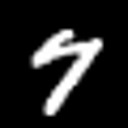

In [33]:
get_raw_image(image_id)

## .lab sbv

In [34]:
# # image_id = RNG.choice(df_train_images.index)
# # image_id = 44917 # 60 points
# image = next(df_train_images.loc[[image_id]].itertuples())
# si_ind_dict = pickle.loads(image.inner_si_ind_dict)
# sequences = pickle.loads(image.inner_sequences)
# seq = get_sequence(sequences)
# seq_xy = get_xy_sequence(seq, si_ind_dict)
# ii = np.all(((seq_xy >= 0) & (seq_xy < config.sample_size)), axis=1) 
# seq_xy = seq_xy[ii]
# ind_seq = (seq_xy @ np.array([1, config.sample_size])).astype(int)
# seq_bv_true = np.zeros((config.sample_size, config.sample_size)).ravel()
# seq_bv_true[ind_seq] = 1

# # seq_sbv = np.where(np.sum(PIXELS[ind_seq], axis=0) > 0, 1, 0) # aka Bloom filter
# seq_sbv = calc_seq_sbv(seq_xy)
# # pixel_sbv_inds = np.argwhere((PIXELS @ seq_sbv) >= SBV_NON_ZERO_INDS).ravel()
# # seq_bv = np.zeros((config.sample_size, config.sample_size)).ravel()
# # seq_bv[pixel_sbv_inds] = 1
# seq_bv = seq_sbv_to_bv(seq_sbv)

# error_level = np.count_nonzero(seq_bv != seq_bv_true)

# fig, (ax1, ax2) = plt.subplots(1, 2)
# fig.set_figwidth(12)
# ax1.set_title(f'image_id={image_id}, points={len(ind_seq)}')
# ax1.imshow(seq_bv_true.reshape(config.sample_size, -1))
# ax2.set_title(f'sbv={seq_sbv.shape[0]} / {seq_sbv.sum()}, non_zero_inds={HP_SIGNAL_VEC_NON_ZERO_BITS}, err.={error_level}')
# ax2.imshow(seq_bv.reshape(config.sample_size, -1));

# Train

In [37]:
LOG.is_enabled = True

In [38]:
HP_CLUSTER_ONES_COUNT_THRES = 6
HP_CLUSTER_CREATION_ONES_COUNT_THRES = 7
HP_CLUSTER_LEARN_BINARIZATION_SCHEDULE = (10, 10)
HP_CLUSTER_RELEARN_BINARIZATION_SCHEDULE = (10,)
HP_CLUSTER_BINARIZE_THRES = 0.75
HP_CLUSTER_PROD_WORK_SIGNALS_PROCESSED_THRES = 10
HP_CLUSTER_PROD_WORK_ACCURACY_THRES = 0.9
HP_CLUSTER_PROD_ETERNAL_SIGNALS_PROCESSED_THRES = 100
HP_CLUSTER_PROD_ETERNAL_ACCURACY_THRES = 0.98
        
HP_LEARN_CLUSTERS_COUNT_HARD_LIMIT = 350_000
HP_LEARN_CLUSTERS_COUNT_SOFT_LIMIT = 300_000
HP_PROD_CANDIDATE_CLUSTERS_COUNT_SOFT_LIMIT = 100_000
HP_PROD_WORK_CLUSTERS_COUNT_SOFT_LIMIT = 100_000

HP_EPOCHS_COUNT = 1
HP_OUTPUT_BITS_PER_BATCH = 250
HP_CYCLES_COUNT = 1000
HP_NEW_SIGNALS_COUNT_PER_CYCLE = min(100, len(df_train_images))
HP_PERSIST_PROD_CLUSTERS_INTERVAL = 100

In [39]:
def persist_prod_clusters():
    persisted_count = 0
    output_bit_to_prod_cluster_metas = defaultdict(list)
    
    for meta in CLUSTER_METAS.values():
        output_bit_to_prod_cluster_metas[meta.output_bit].append(meta)
    
    for output_bit, metas in output_bit_to_prod_cluster_metas.items():
        cluster_inds = list(map(lambda m: m.cluster_ind, metas))
        # Leave only super clusters, i.e. clusters which are not subsets of any other clusters
        clusters = CLUSTERS.array[cluster_inds]
        cluster_ones_counts = clusters.sum(axis=1)
        crossings = (clusters @ clusters.T)
        crossings[xp.diag_indices_from(crossings)] = 0
        super_clusters_boolmap = ~xp.any((crossings.T >= cluster_ones_counts).T, axis=1)
    
        clusters = xp_array_from_gpu(clusters[super_clusters_boolmap])
        super_clusters_boolmap = xp_array_from_gpu(super_clusters_boolmap)
        
        nzb_list = list(map(sbv_to_nzb, clusters))
        pickled_nzb_list = pickle.dumps(nzb_list)
        pickled_metas = pickle.dumps(list(map(lambda x: x[1], filter(lambda x: x[0], zip(super_clusters_boolmap, metas)))))
        # Changing autocommit to False will open a new transaction, and changing it to True will commit any pending transaction.
        # https://docs.python.org/3/library/sqlite3.html#connection-objects
        transfs_db_con.autocommit = False
        transfs_db_con.execute('DELETE FROM clusters WHERE encoding=:encoding AND transf_code=:transf_code AND output_bit=:output_bit',
                               {'encoding': HP_SIGNAL_ENCODING, 'transf_code': TRANSF_CODE, 'output_bit': output_bit})
        transfs_db_con.execute('INSERT INTO clusters (encoding, transf_code, output_bit, metas, nzb_list) VALUES (:encoding, :transf_code, :output_bit, :metas, :nzb_list)',
                               {'encoding': HP_SIGNAL_ENCODING, 'transf_code': TRANSF_CODE, 'output_bit': output_bit, 'metas': pickled_metas, 'nzb_list': pickled_nzb_list})
        transfs_db_con.autocommit = True
        persisted_count += clusters.shape[0]
        LOG(f'Persisted {clusters.shape[0]} (of {len(cluster_inds)}) super clusters for output bit {output_bit}')
    
    LOG(f'Persisted {persisted_count} clusters in total for encoding="{HP_SIGNAL_ENCODING}" and transf_code="{TRANSF_CODE}"')

In [87]:
class LearnClustersSidecar(HdvArrayObserver):
    def __init__(self):
        self.cluster_states_counter = Counter()
        self.cluster_states = []
        
        self.masks = xp.array([], dtype='f')
        self.output_bits = np.array([], dtype='i')
        self.nus = np.array([], dtype='f')

        self.is_dead_boolmap = np.array([], dtype=bool)
        self.is_updatable_boolmap = np.array([], dtype=bool)
        self.is_binarizable_boolmap = np.array([], dtype=bool)
        self.is_promotable_boolmap = np.array([], dtype=bool)

    def size_changed(self, new_size):
        assert new_size > len(self.cluster_states)
        self.cluster_states = self.cluster_states + [''] * (new_size - len(self.cluster_states))
        
        self.masks = xp.resize(self.masks, (new_size, HP_SIGNAL_VEC_LEN))
        self.output_bits = np.resize(self.output_bits, new_size)
        self.nus = np.resize(self.nus, new_size)
        
        self.is_dead_boolmap = np.resize(self.is_dead_boolmap, new_size)
        self.is_updatable_boolmap = np.resize(self.is_updatable_boolmap, new_size)
        self.is_binarizable_boolmap = np.resize(self.is_binarizable_boolmap, new_size)
        self.is_promotable_boolmap = np.resize(self.is_promotable_boolmap, new_size)

    def sync(self, cluster_meta):
        cluster_ind = cluster_meta.cluster_ind
        old_cluster_state = self.cluster_states[cluster_ind]

        if old_cluster_state:
            self.cluster_states_counter[old_cluster_state] -= 1
            
        self.cluster_states[cluster_ind] = cluster_meta.state.name
        self.cluster_states_counter[cluster_meta.state.name] += 1

        self.output_bits[cluster_ind] = cluster_meta.output_bit
        self.nus[cluster_ind] = cluster_meta.nu

        self.is_dead_boolmap[cluster_ind] = cluster_meta.state == ClusterState.DEAD
        is_binarizable = cluster_meta.state == ClusterState.LEARN and cluster_meta.signals_to_learn_till_binarization <= 0
        self.is_updatable_boolmap[cluster_ind] = not is_binarizable
        self.is_binarizable_boolmap[cluster_ind] = is_binarizable
        self.is_promotable_boolmap[cluster_ind] = cluster_meta.state == ClusterState.LEARN and not cluster_meta.binarization_schedule

    def remove(self, cluster_meta):
        cluster_ind = cluster_meta.cluster_ind
        old_cluster_state = self.cluster_states[cluster_ind]

        if old_cluster_state:
            self.cluster_states_counter[old_cluster_state] -= 1
            
        self.cluster_states[cluster_ind] = ''
        
        self.output_bits[cluster_ind] = -1
        self.nus[cluster_ind] = 0

        self.is_dead_boolmap[cluster_ind] = False
        self.is_updatable_boolmap[cluster_ind] = False
        self.is_binarizable_boolmap[cluster_ind] = False
        self.is_promotable_boolmap[cluster_ind] = False

class ClustersSidecar(HdvArrayObserver):
    def __init__(self):
        self.cluster_states_counter = Counter()
        self.cluster_states = []
        
        self.output_bits = np.array([], dtype='i')
        self.ones_counts = np.array([], dtype='f')

        self.is_dead_boolmap = np.array([], dtype=bool)
        self.is_verifiable_boolmap = np.array([], dtype=bool)
        self.is_promotable_to_prod_work_boolmap = np.array([], dtype=bool)
        self.is_prod_work_boolmap = np.array([], dtype=bool)

    def size_changed(self, new_size):
        assert new_size > len(self.cluster_states)
        self.cluster_states = self.cluster_states + [''] * (new_size - len(self.cluster_states))
        
        self.output_bits = np.resize(self.output_bits, new_size)
        self.ones_counts = np.resize(self.ones_counts, new_size)
        
        self.is_dead_boolmap = np.resize(self.is_dead_boolmap, new_size)
        self.is_verifiable_boolmap = np.resize(self.is_verifiable_boolmap, new_size)
        self.is_promotable_to_prod_work_boolmap = np.resize(self.is_promotable_to_prod_work_boolmap, new_size)
        self.is_prod_work_boolmap = np.resize(self.is_prod_work_boolmap, new_size)

    def sync(self, cluster_meta):
        cluster_ind = cluster_meta.cluster_ind
        old_cluster_state = self.cluster_states[cluster_ind]

        if old_cluster_state:
            self.cluster_states_counter[old_cluster_state] -= 1
            
        self.cluster_states[cluster_ind] = cluster_meta.state.name
        self.cluster_states_counter[cluster_meta.state.name] += 1
        
        self.output_bits[cluster_ind] = cluster_meta.output_bit
        self.ones_counts[cluster_ind] = cluster_meta.ones_count

        self.is_dead_boolmap[cluster_ind] = cluster_meta.state == ClusterState.DEAD
        self.is_verifiable_boolmap[cluster_ind] = cluster_meta.state in [ClusterState.PROD_CANDIDATE, ClusterState.PROD_WORK]
        self.is_promotable_to_prod_work_boolmap[cluster_ind] = cluster_meta.state == ClusterState.PROD_CANDIDATE and len(cluster_meta.verify_signal_ids) >= HP_CLUSTER_PROD_WORK_SIGNALS_PROCESSED_THRES
        self.is_prod_work_boolmap[cluster_ind] = cluster_meta.state == ClusterState.PROD_WORK

    def remove(self, cluster_meta):
        cluster_ind = cluster_meta.cluster_ind
        old_cluster_state = self.cluster_states[cluster_ind]

        if old_cluster_state:
            self.cluster_states_counter[old_cluster_state] -= 1
            
        self.cluster_states[cluster_ind] = ''
        
        self.output_bits[cluster_ind] = -1
        self.ones_counts[cluster_ind] = -1

        self.is_dead_boolmap[cluster_ind] = False
        self.is_verifiable_boolmap[cluster_ind] = False
        self.is_promotable_to_prod_work_boolmap[cluster_ind] = False
        self.is_prod_work_boolmap[cluster_ind] = False

In [89]:
# batch_output_bits_filter = lambda s, e: True
batch_output_bits_filter = lambda s, e: s >= 750 and s < 1000
generate_signals = get_signals_generator(TRANSF, HP_NEW_SIGNALS_COUNT_PER_CYCLE, 10)

for epoch in tqdm(range(HP_EPOCHS_COUNT), desc='Epoch'):
    with LOG.auto_prefix('EPOCH', epoch):
        for start_output_bit in tqdm(range(0, HP_SIGNAL_VEC_LEN, HP_OUTPUT_BITS_PER_BATCH), leave=False, desc='Output bit batch'):
            end_output_bit = start_output_bit + HP_OUTPUT_BITS_PER_BATCH - 1
            end_output_bit = min(end_output_bit, HP_SIGNAL_VEC_LEN - 1)
            assert end_output_bit >= start_output_bit, (start_output_bit, end_output_bit)

            if not batch_output_bits_filter(start_output_bit, end_output_bit):
                continue
            
            with LOG.auto_prefix('OBITS', f'{start_output_bit}:{end_output_bit}'):
                CLUSTERS_SIDECAR = ClustersSidecar()
                CLUSTERS = HdvArray(HP_SIGNAL_VEC_LEN, xp, initial_length=100_000, dtype='f', grow_policy=hdv_array_log_like_grow_policy, observer=CLUSTERS_SIDECAR)
                CLUSTER_METAS = {}
                
                LEARN_CLUSTERS_SIDECAR = LearnClustersSidecar()
                LEARN_CLUSTERS = HdvArray(HP_SIGNAL_VEC_LEN, xp, initial_length=100_000, dtype='f', grow_policy=hdv_array_log_like_grow_policy, observer=LEARN_CLUSTERS_SIDECAR)
                LEARN_CLUSTER_METAS = {}
                
                ## Select points for output bits (OBITS)
                points_mask = (POINT_OUTPUT_BITS >= start_output_bit) & (POINT_OUTPUT_BITS <= end_output_bit)
                points = xp_array_to_gpu(POINTS[points_mask])
                point_output_bits = POINT_OUTPUT_BITS[points_mask]
                point_inds = np.arange(points.shape[0])
                LOG(f'{points.shape[0]} combinatorial points selected for output bits {start_output_bit}:{end_output_bit}, avg. points per output bit={points.shape[0] / ((end_output_bit - start_output_bit) + 1):.0f}')
                assert points.shape[0] > 0

                ## Restore prod clusters for output bits (OBITS)
                df_clusters = pd.read_sql('SELECT ROWID, output_bit, metas, nzb_list FROM clusters WHERE encoding=:encoding AND transf_code=:transf_code ' + 
                                          'AND output_bit>=:start_output_bit AND output_bit<=:end_output_bit', 
                                          params={
                                              'encoding': HP_SIGNAL_ENCODING, 
                                              'transf_code': TRANSF_CODE,
                                              'start_output_bit': start_output_bit, 
                                              'end_output_bit': end_output_bit}, 
                                          con=transfs_db_con)
                
                clusters = []
                cluster_inds = []
                
                for cluster_row in df_clusters.itertuples():
                    cluster_nzb_list_for_output_bit = pickle.loads(cluster_row.nzb_list)
                    cluster_metas_for_output_bit = pickle.loads(cluster_row.metas)
                    assert len(cluster_nzb_list_for_output_bit) == len(cluster_metas_for_output_bit)

                    for nzb, meta in zip(cluster_nzb_list_for_output_bit, cluster_metas_for_output_bit):
                        assert len(nzb) > 0
                        cluster = np.zeros(HP_SIGNAL_VEC_LEN, dtype='f')
                        cluster[nzb] = 1
                        clusters.append(cluster)
                        
                        cluster_ind = CLUSTERS.lease()
                        meta.cluster_ind = cluster_ind
                        cluster_inds.append(cluster_ind)
                        
                        CLUSTER_METAS[cluster_ind] = meta
                        CLUSTERS_SIDECAR.sync(meta)

                    LOG(f'Loaded {len(cluster_metas_for_output_bit)} clusters for output bit {cluster_row.output_bit} (ROWID={cluster_row.rowid})')

                if clusters:
                    assert len(clusters) == len(cluster_inds)
                    CLUSTERS.array[cluster_inds] = np.vstack(clusters)
                    assert len(CLUSTER_METAS) == CLUSTERS.len
                    
                LOG(f'Loaded {len(CLUSTER_METAS)} clusters in total for encoding="{HP_SIGNAL_ENCODING}" and transf_code="{TRANSF_CODE}"')

                unique_cluster_keys = set(map(lambda m: m.cluster_key, CLUSTER_METAS.values()))
                assert len(unique_cluster_keys) == len(CLUSTER_METAS)
                new_clusters_count_avg_speed_calc = AverageFilter()
                
                ## Mine clusters
                for cycle in tqdm(range(HP_CYCLES_COUNT), leave=False, desc='Cycle'):
                    with LOG.auto_prefix('CYCLE', cycle):
                        LOG(f'===')
                        cluster_states = {}
                        cluster_states.update(LEARN_CLUSTERS_SIDECAR.cluster_states_counter.most_common())
                        cluster_states.update(CLUSTERS_SIDECAR.cluster_states_counter.most_common())
                        assert cluster_states.get(ClusterState.LEARN.name, 0) == len(LEARN_CLUSTER_METAS)
                        LOG(f'Cycle {cycle} started, clusters: {cluster_states}, LEARN_CLUSTERS.array.shape={LEARN_CLUSTERS.array.shape}, CLUSTERS.array.shape={CLUSTERS.array.shape}')
                        
                        ### Prepare input and output signals for training
                        sgr = generate_signals()
                        cycle_signal_ids = sgr.signal_ids
                        signals_input = xp.vstack(sgr.signals_input)
                        signals_output = np.vstack(sgr.signals_output)
                        assert len(cycle_signal_ids) == signals_input.shape[0]
                        assert signals_input.shape[0] == signals_output.shape[0]
                        LOG(f'Prepared {signals_input.shape[0]} signals')
                        # assert False

                        ### Create new clusters
                        learn_clusters_count = len(LEARN_CLUSTER_METAS)
                        new_clusters = []
                        new_cluster_inds = []

                        if cycle < 10:
                            signals_count_for_new_clusters = cycle + 1
                        else:
                            avg_speed = new_clusters_count_avg_speed_calc.value
                            reserve = HP_LEARN_CLUSTERS_COUNT_SOFT_LIMIT - learn_clusters_count
                            signals_count_for_new_clusters = max(0, int(reserve / avg_speed))

                        signals_count_for_new_clusters = min(signals_count_for_new_clusters, signals_input.shape[0])

                        for signal_input, signal_output in zip(signals_input[:signals_count_for_new_clusters], signals_output[:signals_count_for_new_clusters]):
                            if learn_clusters_count > HP_LEARN_CLUSTERS_COUNT_HARD_LIMIT: 
                                break

                            active_points_boolmap = signal_output[point_output_bits] != 0
                            active_point_inds = point_inds[active_points_boolmap]

                            if active_point_inds.shape[0] == 0:
                                new_clusters_count_avg_speed_calc(0)
                                continue
                                
                            active_points = points[active_point_inds] # subset of points which are connected to active output bits
                            active_points_signal_input_mat = active_points * signal_input
                            active_points_signal_input_mask = (active_points_signal_input_mat.sum(axis=1) >= HP_CLUSTER_CREATION_ONES_COUNT_THRES) # active_points must have at least ON bits within input signal
                            active_points_signal_input_mat = xp_array_from_gpu(active_points_signal_input_mat)
                            active_points_signal_input_inds = np.flatnonzero(xp_array_from_gpu(active_points_signal_input_mask))
                            learn_clusters_count0 = learn_clusters_count
                            
                            for active_points_signal_input_ind in active_points_signal_input_inds:
                                point_ind = active_point_inds[active_points_signal_input_ind]
                                subsignal_input = active_points_signal_input_mat[active_points_signal_input_ind]
                                
                                active_output_bit = int(point_output_bits[point_ind])
                                active_input_bits = np.flatnonzero(subsignal_input)
                                assert active_input_bits.shape[0] >= HP_CLUSTER_CREATION_ONES_COUNT_THRES
                                cluster_key = get_cluster_key(active_output_bit, active_input_bits)
                    
                                if cluster_key in unique_cluster_keys:
                                    continue
                    
                                # GPU doesn't honor frequent uploads of data - it renders way to slow execution.
                                # as such during clusters-creation-loop a) stage new clusters on CPU b) reserve indices in GPU array
                                # At the end bulk upload to GPU
                                cluster_ind = LEARN_CLUSTERS.lease()
                                new_clusters.append(subsignal_input)
                                new_cluster_inds.append(cluster_ind)
                                
                                cluster_meta = ClusterMeta(cluster_ind)
                                cluster_meta.cluster_key = cluster_key
                                cluster_meta.output_bit = active_output_bit
                                cluster_meta.input_bits = tuple(active_input_bits)
                                cluster_meta.nu = 1 / subsignal_input.sum()
                                cluster_meta.binarization_schedule = HP_CLUSTER_LEARN_BINARIZATION_SCHEDULE
                                cluster_meta.signals_to_learn_till_binarization = cluster_meta.binarization_schedule[0]
                                cluster_meta.last_activity_cycle = cycle
                                assert not cluster_ind in LEARN_CLUSTER_METAS
                                LEARN_CLUSTER_METAS[cluster_ind] = cluster_meta
                                LEARN_CLUSTERS_SIDECAR.sync(cluster_meta)
                                unique_cluster_keys.add(cluster_key)
                                learn_clusters_count += 1

                            new_clusters_count_for_signal = learn_clusters_count - learn_clusters_count0
                            new_clusters_count_avg_speed_calc(new_clusters_count_for_signal if new_clusters_count_for_signal > 0 else 0)

                        LOG(f'Created {len(new_clusters)} clusters from {signals_count_for_new_clusters} signals, avg. speed={new_clusters_count_avg_speed_calc.value:.0f} clusters/signal')

                        if new_clusters:
                            new_cluster_inds = np.array(new_cluster_inds)
                            new_clusters = np.vstack(new_clusters)
                            assert new_clusters.shape[0] == new_cluster_inds.shape[0]
                            LEARN_CLUSTERS.array[new_cluster_inds] = new_clusters
                            LEARN_CLUSTERS_SIDECAR.masks[new_cluster_inds] = new_clusters
                            LOG(f'{new_clusters.shape[0]} clusters uploaded to GPU')

                        ### Learn clusters
                        # LEARN_CLUSTERS and all items in LEARN_CLUSTERS_SIDECAR are sparsed arrays. It seems to be a good idea to select only
                        # present entries (and omit missing) and learn them. But this would render huge load on GPU memory because these entries
                        # must be stored in a separate contigous array! As such operate on active part of both arrays (array_active) without extra copying
                        learn_clusters = LEARN_CLUSTERS.array_active
                        learn_cluster_masks = LEARN_CLUSTERS_SIDECAR.masks[:learn_clusters.shape[0]]
                        learn_cluster_nus = xp_array_to_gpu(LEARN_CLUSTERS_SIDECAR.nus[:learn_clusters.shape[0]])
                        learn_cluster_inds = np.arange(learn_clusters.shape[0], dtype='i')
                        learn_cluster_output_bits = LEARN_CLUSTERS_SIDECAR.output_bits[:learn_clusters.shape[0]]
                        # following boolmap is used to promptly exclude from learning those clusters which reached binarization threshold
                        learn_clusters_is_updatable_boolmap = LEARN_CLUSTERS_SIDECAR.is_updatable_boolmap[:learn_clusters.shape[0]]
                        assert learn_clusters.shape == learn_cluster_masks.shape
                        assert learn_clusters.shape[0] == learn_cluster_nus.shape[0]
                        assert learn_clusters.shape[0] == learn_cluster_inds.shape[0]
                        assert learn_clusters.shape[0] == learn_cluster_output_bits.shape[0]
                        assert learn_clusters.shape[0] == learn_clusters_is_updatable_boolmap.shape[0]
                        assert not learn_clusters_is_updatable_boolmap.base is None
                        learned_clusters_inds = set()
                        learn_updates_count = 0

                        for signal_input, signal_output in zip(signals_input, signals_output):
                            # this stanza 'signal_output[learn_cluster_output_bits] != 0' effectively produces
                            # boolean array index (boolmap) for learn_clusters - clusters which are connected to currently active output bits
                            learn_clusters_boolmap = signal_output[learn_cluster_output_bits] != 0
                            assert learn_clusters_boolmap.shape[0] == learn_clusters.shape[0]
                            learn_clusters_boolmap = learn_clusters_boolmap & learn_clusters_is_updatable_boolmap
                            active_cluster_inds = learn_cluster_inds[learn_clusters_boolmap]
                            
                            if active_cluster_inds.shape[0] == 0:
                                continue

                            # narrow down clusters to those which have enough bits touched by signal
                            # (i.e. we dont want to update clusters which have e.g. 1 or 2 bit touched out of minimal count (say 10))
                            active_cluster_masks = learn_cluster_masks[active_cluster_inds]
                            zs = signal_input @ active_cluster_masks.T # number of activated bits within each cluster for given signal_input, ca. shape (35,)
                            zs = xp_array_from_gpu(zs)
                            active_cluster_inds = active_cluster_inds[zs >= HP_CLUSTER_ONES_COUNT_THRES]
                        
                            if active_cluster_inds.shape[0] == 0:
                                continue
                            
                            active_clusters = learn_clusters[active_cluster_inds] # subset of CLUSTERS which are connected to active bits in signal_output
                            active_cluster_masks = learn_cluster_masks[active_cluster_inds]
                            active_cluster_nus = learn_cluster_nus[active_cluster_inds]

                            ys = signal_input @ active_clusters.T # how each cluster reacted on signal_input (strength), ca. shape (35,).
                            grow = (signal_input * (active_cluster_nus * ys)[:,np.newaxis]) # how weights within each cluster must grow up in response to signal_input, matrix, ca. shape (35, 1024)
                            grow *= active_cluster_masks # masking, only allow weights which belong to clusters to grow up, matrix, ca. shape (35, 1024)
                            nomins = active_clusters + grow # grow weights within clusters
                            denoms = nomins.max(axis=1) 
                            active_clusters = (nomins.T / denoms).T  # upload updated weights
                    
                            for cluster_ind in active_cluster_inds:
                                cluster_meta = LEARN_CLUSTER_METAS[cluster_ind]
                                assert cluster_meta.state == ClusterState.LEARN
                                assert cluster_meta.signals_to_learn_till_binarization > 0
                                assert signal_output[cluster_meta.output_bit] == 1
                                cluster_meta.last_activity_cycle = cycle
                                cluster_meta.signals_learned += 1
                                cluster_meta.signals_to_learn_till_binarization -= 1
                                LEARN_CLUSTERS_SIDECAR.sync(cluster_meta)
                                learned_clusters_inds.add(cluster_ind)
                                learn_updates_count += 1

                        LOG(f'Learned {len(learned_clusters_inds)} clusters with {learn_updates_count} updates')

                        ### Binarize LEARN clusters (develop specialization)
                        is_binarizable_boolmap = LEARN_CLUSTERS_SIDECAR.is_binarizable_boolmap[:LEARN_CLUSTERS.active_len]
                        cluster_inds_to_binarize = np.arange(LEARN_CLUSTERS.active_len, dtype='i')[is_binarizable_boolmap]
                        new_cluster_states = Counter()
                        death_reasons = Counter()

                        if cluster_inds_to_binarize.shape[0] > 0:
                            binarized_clusters = xp.where(learn_clusters[cluster_inds_to_binarize] > HP_CLUSTER_BINARIZE_THRES, 1, 0)
                            learn_clusters[cluster_inds_to_binarize] = binarized_clusters
                            learn_cluster_masks[cluster_inds_to_binarize] = binarized_clusters
                            binarized_clusters_ones_counts = xp_array_from_gpu(binarized_clusters.sum(axis=1))
                            binarized_clusters = xp_array_from_gpu(binarized_clusters)
                        
                            for cluster_ind, cluster, ones_count in zip(cluster_inds_to_binarize, binarized_clusters, binarized_clusters_ones_counts):
                                cluster_meta = LEARN_CLUSTER_METAS[cluster_ind]
                                assert cluster_meta.state == ClusterState.LEARN
                                assert cluster_meta.signals_to_learn_till_binarization <= 0
                                cluster_ind = cluster_meta.cluster_ind
                                cluster_meta.last_activity_cycle = cycle
                                cluster_meta.binarization_schedule = cluster_meta.binarization_schedule[1:]
                                cluster_meta.signals_to_learn_till_binarization = cluster_meta.binarization_schedule[0] if cluster_meta.binarization_schedule else 0
                                cluster_meta.ones_count = int(ones_count)
                                assert cluster_meta.ones_count > 0
                                cluster_meta.nu = 1 / cluster_meta.ones_count
                    
                                if cluster_meta.ones_count >= HP_CLUSTER_ONES_COUNT_THRES:
                                    old_cluster_key = cluster_meta.cluster_key
                                    cluster_meta.input_bits = tuple(np.flatnonzero(cluster))
                                    new_cluster_key = get_cluster_key(cluster_meta.output_bit, cluster_meta.input_bits)
    
                                    if old_cluster_key != new_cluster_key:
                                        if new_cluster_key in unique_cluster_keys:
                                            cluster_meta.state = ClusterState.DEAD
                                            death_reasons['DUPLICATE'] += 1
                                        else:
                                            cluster_meta.cluster_key = new_cluster_key
                                            unique_cluster_keys.remove(old_cluster_key)
                                            unique_cluster_keys.add(new_cluster_key)
                                else:
                                    cluster_meta.state = ClusterState.DEAD
                                    death_reasons['SHORT'] += 1

                                LEARN_CLUSTERS_SIDECAR.sync(cluster_meta)
                                new_cluster_states[cluster_meta.state.name] += 1

                        LOG(f'Binarized {len(cluster_metas_to_binarize)} clusters: {new_cluster_states}; death reasons: {death_reasons}')
                        # assert False
                        
                        ### Promote LEARN clusters to PROD_CANDIDATE if they've learned enough (binarization schedule is exhausted)
                        is_promotable_boolmap = LEARN_CLUSTERS_SIDECAR.is_promotable_boolmap[:LEARN_CLUSTERS.active_len]
                        cluster_inds_to_promote = np.arange(LEARN_CLUSTERS.active_len)[is_promotable_boolmap]
                        new_cluster_states = Counter()
                        
                        for cluster_ind in cluster_inds_to_promote:
                            cluster_meta = LEARN_CLUSTER_METAS[cluster_ind]
                            assert cluster_meta.state == ClusterState.LEARN
                            assert not cluster_meta.binarization_schedule
                            assert cluster_meta.ones_count >= HP_CLUSTER_ONES_COUNT_THRES
                            cluster_ind = cluster_meta.cluster_ind
                            cluster_meta.last_activity_cycle = cycle
                            cluster_meta.state = ClusterState.PROD_CANDIDATE
                            cluster_meta.accuracy_calc = AverageFilter()
                            cluster_meta.verify_signal_ids.clear()
                            del LEARN_CLUSTER_METAS[cluster_ind]
                            LEARN_CLUSTERS_SIDECAR.remove(cluster_meta)
                            LEARN_CLUSTERS.release(cluster_ind, do_wipeout_data=False)

                            # move to PROD_CANDIDATE under new cluster_ind
                            cluster_meta.cluster_ind = CLUSTERS.lease()
                            CLUSTERS.array[cluster_meta.cluster_ind] = LEARN_CLUSTERS.array[cluster_ind]
                            assert not cluster_meta.cluster_ind in CLUSTER_METAS
                            CLUSTER_METAS[cluster_meta.cluster_ind] = cluster_meta
                            CLUSTERS_SIDECAR.sync(cluster_meta)
                            
                            new_cluster_states[cluster_meta.state.name] += 1

                        LOG(f'Promoted {new_cluster_states.total()} LEARN clusters: {new_cluster_states}')

                        ### Verify PROD_CANDIDATE/PROD_WORK clusters against new signals
                        verify_cluster_inds = np.arange(CLUSTERS.array.shape[0])[CLUSTERS_SIDECAR.is_verifiable_boolmap]
                        verify_cluster_ones_counts = xp_array_to_gpu(CLUSTERS_SIDECAR.ones_counts[verify_cluster_inds])
                        verify_cluster_output_bits = CLUSTERS_SIDECAR.output_bits[verify_cluster_inds]
                        verify_clusters = CLUSTERS.array[verify_cluster_inds]
                        verified_cluster_inds = set()
                        # row - signal input, column - how many bits are activated in verify cluster for corresponding signal_input
                        signal_input_to_activated_clusters_boolmap_mat = signals_input @ verify_clusters.T
                        # row - signal_input, column - true if corresponding verify cluster have enough bits activated, false otherwise
                        signal_input_to_activated_clusters_boolmap_mat = (signal_input_to_activated_clusters_boolmap_mat >= verify_cluster_ones_counts)
                        signal_input_to_activated_clusters_boolmap_mat = xp_array_from_gpu(signal_input_to_activated_clusters_boolmap_mat)
                        assert signal_input_to_activated_clusters_boolmap_mat.shape[0] == signals_output.shape[0]
                        assert signal_input_to_activated_clusters_boolmap_mat.shape[0] == len(cycle_signal_ids)
                        
                        for activated_clusters_boolmap, signal_output, signal_id in zip(signal_input_to_activated_clusters_boolmap_mat, 
                                                                                        signals_output, cycle_signal_ids):
                            # cast array of output_bit numbers [0, 3, 4, 7, 7, 0, 3, 32, ..] to TP array [True, False, False, True, True, True, False, False, ...]
                            # where True if output_bit of verify_cluster is enabled in signal_output and False otherwise
                            verify_cluster_output_bits_tf = signal_output[verify_cluster_output_bits] != 0
                            cluster_inds = verify_cluster_inds[activated_clusters_boolmap]
                            tfs = verify_cluster_output_bits_tf[activated_clusters_boolmap]
                            assert cluster_inds.shape[0] == tfs.shape[0]
                            
                            for cluster_ind, tf in zip(cluster_inds, tfs):
                                cluster_meta = CLUSTER_METAS[cluster_ind]
                                cluster_meta.last_activity_cycle = cycle
                                cluster_meta.accuracy_calc(int(tf))
                                cluster_meta.verify_signal_ids.append((signal_id, int(tf)))
                                CLUSTERS_SIDECAR.sync(cluster_meta)
                                verified_cluster_inds.add(cluster_ind)
                    
                        LOG(f'Verified {len(verified_cluster_inds)} PROD_* clusters')

                        ### Promote PROD_CANDIDATE clusters to PROD_WORK if they've been verified enough
                        is_promotable_to_prod_work_boolmap = CLUSTERS_SIDECAR.is_promotable_to_prod_work_boolmap[:CLUSTERS.active_len]
                        cluster_inds_to_promote = np.arange(CLUSTERS.active_len)[is_promotable_to_prod_work_boolmap]
                        new_cluster_states = Counter()
                        
                        for cluster_ind in cluster_inds_to_promote:
                            cluster_meta = CLUSTER_METAS[cluster_ind]
                            assert cluster_meta.state == ClusterState.PROD_CANDIDATE
                            assert len(cluster_meta.verify_signal_ids) >= HP_CLUSTER_PROD_WORK_SIGNALS_PROCESSED_THRES
                            assert cluster_meta.ones_count >= HP_CLUSTER_ONES_COUNT_THRES
                            cluster_meta.state = ClusterState.PROD_WORK
                            cluster_meta.accuracy_calc = MovingAverageFilter(HP_CLUSTER_PROD_ETERNAL_SIGNALS_PROCESSED_THRES)
                            
                            for verify_signal_id in cluster_meta.verify_signal_ids:
                                cluster_meta.accuracy_calc(verify_signal_id[1])

                            CLUSTERS_SIDECAR.sync(cluster_meta)
                            new_cluster_states[cluster_meta.state.name] += 1
                    
                        LOG(f'Promoted {new_cluster_states.total()} PROD_CANDIDATE clusters: {new_cluster_states}')

                        ### Promote PROD_WORK clusters to PROD_ETERNAL or depromote back to LEARN based on accuracy and experience
                        is_prod_work_boolmap = CLUSTERS_SIDECAR.is_prod_work_boolmap[:CLUSTERS.active_len]
                        cluster_inds_to_promote = np.arange(CLUSTERS.active_len)[is_prod_work_boolmap]
                        new_cluster_states = Counter()
                        
                        for cluster_ind in cluster_inds_to_promote:
                            cluster_meta = CLUSTER_METAS[cluster_ind]
                            assert cluster_meta.state == ClusterState.PROD_WORK
                            assert cluster_meta.ones_count >= HP_CLUSTER_ONES_COUNT_THRES
                            accuracy = cluster_meta.accuracy_calc.value

                            if accuracy < HP_CLUSTER_PROD_WORK_ACCURACY_THRES:
                                # bad, bad, bad prod-work cluster. You are too inaccurate, you are depromoted back to LEARN so you've a chance to fix your behavior
                                cluster_ind = cluster_meta.cluster_ind
                                del CLUSTER_METAS[cluster_ind]
                                CLUSTERS.release(cluster_ind, do_wipeout_data=False)
                                CLUSTERS_SIDECAR.remove(cluster_meta)
                                
                                cluster_meta.cluster_ind = LEARN_CLUSTERS.lease()
                                cluster_meta.state = ClusterState.LEARN
                                assert cluster_meta.cluster_key in unique_cluster_keys
                                cluster_meta.nu = 1 / cluster_meta.ones_count
                                cluster_meta.signals_learned = 0
                                cluster_meta.binarization_schedule = HP_CLUSTER_RELEARN_BINARIZATION_SCHEDULE
                                cluster_meta.signals_to_learn_till_binarization = cluster_meta.binarization_schedule[0]
                                cluster_meta.accuracy_calc = None
                                cluster_meta.verify_signal_ids.clear()
                                
                                assert not cluster_meta.cluster_ind in LEARN_CLUSTER_METAS
                                LEARN_CLUSTER_METAS[cluster_meta.cluster_ind] = cluster_meta
                                LEARN_CLUSTERS.array[cluster_meta.cluster_ind] = CLUSTERS.array[cluster_ind]
                                LEARN_CLUSTERS_SIDECAR.masks[cluster_meta.cluster_ind] = CLUSTERS.array[cluster_ind]
                                LEARN_CLUSTERS_SIDECAR.sync(cluster_meta)
                                
                            elif len(cluster_meta.verify_signal_ids) >= HP_CLUSTER_PROD_ETERNAL_SIGNALS_PROCESSED_THRES and accuracy >= HP_CLUSTER_PROD_ETERNAL_ACCURACY_THRES:
                                # Elite cluster is born! Promote to pantheon of eternal clusters
                                cluster_meta.state = ClusterState.PROD_ETERNAL
                                CLUSTERS_SIDECAR.sync(cluster_meta)
                            else:
                                continue
                                
                            new_cluster_states[cluster_meta.state.name] += 1
                    
                        LOG(f'Promoted {new_cluster_states.total()} PROD_WORK clusters: {new_cluster_states}')
                    
                        ### Weed the garden
                        def remove_cluster(meta, metas, clusters, clusters_sidecar):
                            unique_cluster_keys.remove(meta.cluster_key)
                            del metas[meta.cluster_ind]
                            clusters.release(meta.cluster_ind, do_wipeout_data=False)
                            clusters_sidecar.remove(meta)
                        
                        def remove_dead_clusters(metas, clusters, clusters_sidecar):
                            is_dead_boolmap = clusters_sidecar.is_dead_boolmap[:clusters.active_len]
                            cluster_inds_to_remove = np.arange(clusters.active_len)[is_dead_boolmap]
                            
                            for cluster_ind in cluster_inds_to_remove:
                                meta = metas[cluster_ind]
                                assert meta.cluster_state == ClusterState.DEAD
                                remove_cluster(meta, metas, clusters, clusters_sidecar)
                                
                            assert len(metas) == clusters.len, (len(metas), clusters.len)
                            return len(cluster_inds_to_remove)

                        def soft_limit_clusters(soft_limit, metas, clusters, clusters_sidecar, cluster_state):
                            metas_of_interest = list(filter(lambda m: m.state == cluster_state, metas.values()))
                            
                            if len(metas_of_interest) <= soft_limit:
                                return 0, -1, -1
                            
                            redundant_metas_count = len(metas_of_interest) - soft_limit
                            assert redundant_metas_count > 0
                            metas_by_inactivity = list(map(lambda m: (m.last_activity_cycle, m.cluster_ind), metas_of_interest))
                            metas_by_inactivity.sort() # most inactive metas will be concentrated at the very beginning
                            most_inactive_metas = metas_by_inactivity[:redundant_metas_count]
                            min_age = cycle - most_inactive_metas[-1][0]
                            max_age = cycle - most_inactive_metas[0][0]
                            most_inactive_metas = list(map(lambda x: metas[x[1]], most_inactive_metas))
                            assert len(most_inactive_metas) == redundant_metas_count
                            
                            for meta in most_inactive_metas:
                                remove_cluster(meta, metas, clusters, clusters_sidecar)
                                
                            assert len(metas) == clusters.len
                            return len(most_inactive_metas), min_age, max_age

                        removed_count = remove_dead_clusters(LEARN_CLUSTER_METAS, LEARN_CLUSTERS, LEARN_CLUSTERS_SIDECAR)
                        LOG(f'Removed {removed_count} dead LEARN clusters')
                        removed_count = remove_dead_clusters(CLUSTER_METAS, CLUSTERS, CLUSTERS_SIDECAR)
                        LOG(f'Removed {removed_count} dead PROD_CANDIDATE clusters')
                        removed_count, min_age, max_age = soft_limit_clusters(HP_LEARN_CLUSTERS_COUNT_SOFT_LIMIT, LEARN_CLUSTER_METAS, LEARN_CLUSTERS, LEARN_CLUSTERS_SIDECAR, ClusterState.LEARN)
                        LOG(f'Removed {removed_count} LEARN clusters by soft limit {HP_LEARN_CLUSTERS_COUNT_SOFT_LIMIT:_}; age=[{min_age}, {max_age}]')
                        removed_count, min_age, max_age = soft_limit_clusters(HP_PROD_CANDIDATE_CLUSTERS_COUNT_SOFT_LIMIT, CLUSTER_METAS, CLUSTERS, CLUSTERS_SIDECAR, ClusterState.PROD_CANDIDATE)
                        LOG(f'Removed {removed_count} PROD_CANDIDATE clusters by soft limit {HP_PROD_CANDIDATE_CLUSTERS_COUNT_SOFT_LIMIT:_}; age=[{min_age}, {max_age}]')
                        removed_count, min_age, max_age = soft_limit_clusters(HP_PROD_WORK_CLUSTERS_COUNT_SOFT_LIMIT, CLUSTER_METAS, CLUSTERS, CLUSTERS_SIDECAR, ClusterState.PROD_WORK)
                        LOG(f'Removed {removed_count} PROD_WORK clusters by soft limit {HP_PROD_WORK_CLUSTERS_COUNT_SOFT_LIMIT:_}; age=[{min_age}, {max_age}]')

                        if HP_PERSIST_PROD_CLUSTERS_INTERVAL > 0 and cycle > 0 and (cycle % HP_PERSIST_PROD_CLUSTERS_INTERVAL) == 0:
                            persist_prod_clusters()

                persist_prod_clusters()

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Output bit batch:   0%|          | 0/4 [00:00<?, ?it/s]

Cycle:   0%|          | 0/1000 [00:00<?, ?it/s]

## Post-train

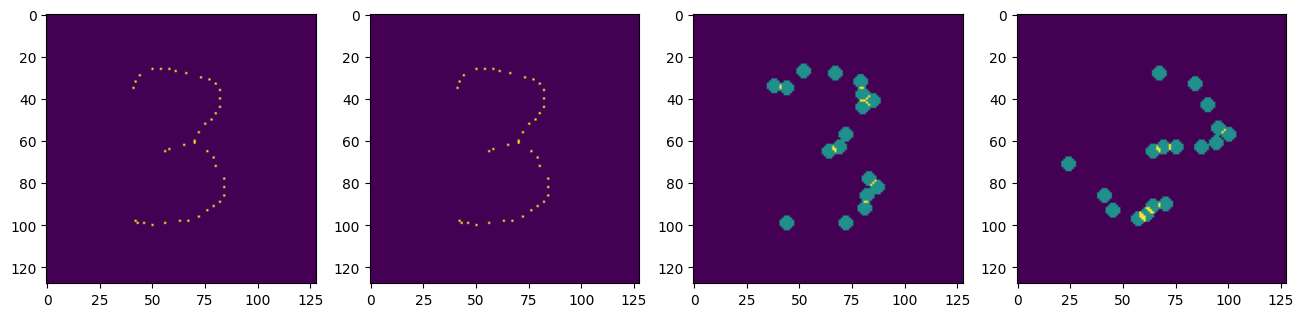

In [62]:
signal_ind = RNG.choice(signals_input.shape[0])
# signal_ind = 0
signal_input = xp_array_from_gpu(signals_input[signal_ind])
signal_output = signals_output[signal_ind]

# xy_list_input = PIXEL_FEATURE_XY_ARRAY[debundle_sbv(signal_input, PIXEL_FEATURE_SBVS, HP_SIGNAL_VEC_NON_ZERO_BITS)]
# xy_list_output = PIXEL_FEATURE_XY_ARRAY[debundle_sbv(signal_output, PIXEL_FEATURE_SBVS, HP_SIGNAL_VEC_NON_ZERO_BITS)]
# ohe_input = xy_list_to_ohe_vec(xy_list_input)
# ohe_output = xy_list_to_ohe_vec(xy_list_output)

pixel_feature_inds = debundle_sbv(signal_input, PIXEL_FEATURE_SBVS, HP_SIGNAL_VEC_NON_ZERO_BITS)
bm_input = PIXEL_FEATURE_BITMAP_MASKS[pixel_feature_inds].sum(axis=0)
pixel_feature_inds = debundle_sbv(signal_output, PIXEL_FEATURE_SBVS, HP_SIGNAL_VEC_NON_ZERO_BITS)
bm_output = PIXEL_FEATURE_BITMAP_MASKS[pixel_feature_inds].sum(axis=0)
    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figwidth(16)
ax1.imshow(vec_to_square_matrix(xy_list_to_ohe_vec(raw_signals_input[signal_ind])))
# ax2.imshow(vec_to_square_matrix(ohe_input))
# ax3.imshow(vec_to_square_matrix(ohe_output));
ax2.imshow(vec_to_square_matrix(bm_input))
ax3.imshow(vec_to_square_matrix(bm_output));

# Test

In [135]:
df_clusters = pd.read_sql('SELECT output_bit, metas, nzb_list FROM clusters WHERE encoding=:encoding AND transf_code=:transf_code', 
                          params={
                              'encoding': HP_SIGNAL_ENCODING, 
                              'transf_code': TRANSF_CODE},
                          con=transfs_db_con)
clusters = []
cluster_metas = []

for cluster_row in tqdm(df_clusters.itertuples(), total=len(df_clusters)):
    cluster_nzb_list_for_output_bit = pickle.loads(cluster_row.nzb_list)
    cluster_metas_for_output_bit = pickle.loads(cluster_row.metas)
    assert len(cluster_nzb_list_for_output_bit) == len(cluster_metas_for_output_bit)

    for nzb, meta in zip(cluster_nzb_list_for_output_bit, cluster_metas_for_output_bit):
        assert len(nzb) > 0
        
        if meta.state in [ClusterState.PROD_WORK, ClusterState.PROD_ETERNAL]:
            cluster = np.zeros(HP_SIGNAL_VEC_LEN, dtype='f')
            cluster[nzb] = 1
            clusters.append(cluster)
        
            cluster_ind = len(clusters)
            meta.cluster_ind = cluster_ind
            cluster_metas.append(meta)

clusters = np.vstack(clusters)
assert clusters.shape[0] == len(cluster_metas)
    
cluster_ones_counts = np.array(list(map(lambda m: m.ones_count, cluster_metas)), dtype='f')
cluster_output_bits = np.array(list(map(lambda m: m.output_bit, cluster_metas)), dtype='i')
cluster_input_bits_list = list(map(lambda m: m.input_bits, cluster_metas))
clusters.shape

  0%|          | 0/816 [00:00<?, ?it/s]

(52792, 1000)

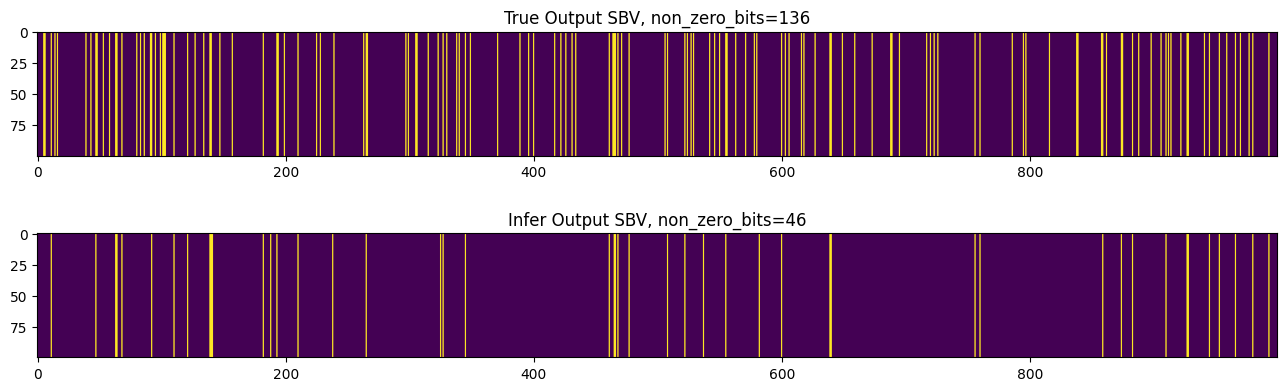

In [134]:
generate_signals = get_signals_generator(TRANSF, 1, 1)
sgr = generate_signals()

input_sbv = sgr.signals_input[0]
true_output_sbv = sgr.signals_output[0]
infer_output_sbv = np.zeros_like(input_sbv)

activated_clusters_boolmap = (clusters @ input_sbv) >= cluster_ones_counts
output_bit_to_activated_clusters_count = Counter(cluster_output_bits[activated_clusters_boolmap])
infer_output_sbv[list(output_bit_to_activated_clusters_count.keys())] = list(output_bit_to_activated_clusters_count.values())
infer_output_sbv = np.where(infer_output_sbv > 0, 1, 0)

fig, (ax1, ax2) = plt.subplots(2, 1)
fig.set_figwidth(16)
ax1.set_title(f'True Output SBV, non_zero_bits={true_output_sbv.sum()}')
ax1.imshow(np.ones((100, 1)) * true_output_sbv);
ax2.set_title(f'Infer Output SBV, non_zero_bits={infer_output_sbv.sum()}')
ax2.imshow(np.ones((100, 1)) * infer_output_sbv);

  0%|          | 0/100 [00:00<?, ?it/s]

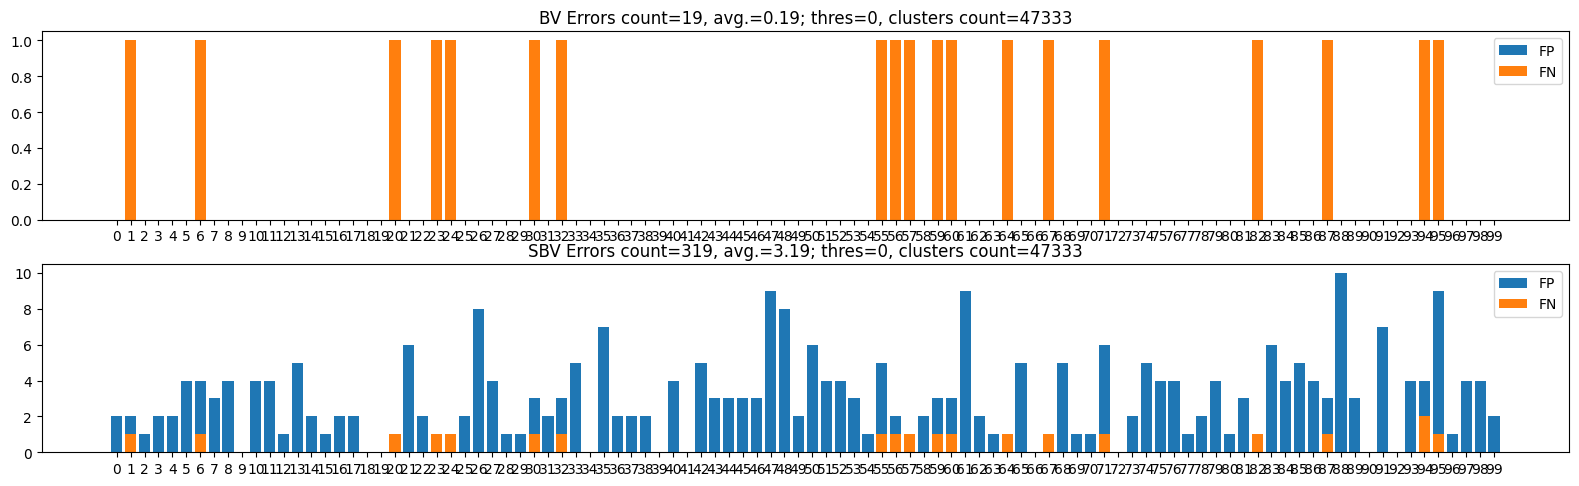

In [107]:
thres = 0
toy_image_ids = get_random_toy_image_ids(100)
bv_errors_count_list = defaultdict(list)
sbv_errors_count_list = defaultdict(list)

for toy_image_id in tqdm(toy_image_ids):
    toy_image_origin = get_toy_image(toy_image_id)
    toy_image_transf = transform_toy_image(toy_image_origin, TRANSF)

    toy_image_origin_sbv = calc_toy_image_sbv(toy_image_origin)
    toy_image_transf_sbv = calc_toy_image_sbv(toy_image_transf)
    
    activated_clusters_mask = (clusters @ toy_image_origin_sbv) >= cluster_ones_counts
    
    toy_image_infer_sbv = np.zeros_like(toy_image_origin_sbv)

    # Approach 1: judge if output_bit is ON/OFF based on number of activated clusters
    output_bit_to_activated_clusters_count = Counter(cluster_output_bits[activated_clusters_mask])
    toy_image_infer_sbv[list(output_bit_to_activated_clusters_count.keys())] = list(output_bit_to_activated_clusters_count.values())
    toy_image_infer_sbv = np.where(toy_image_infer_sbv > thres, 1, 0)

    # Approach 2: judge if output_bit is ON/OFF based on number of unique bits touched by clusters within input signal
    # output_bit_to_unique_input_bits = defaultdict(set)

    # for mask_value, output_bit, input_bits in zip(activated_clusters_mask, cluster_output_bits, cluster_input_bits_list):
    #     if not mask_value:
    #         continue

    #     output_bit_to_unique_input_bits[output_bit].update(input_bits)
    # toy_image_infer_sbv[list(output_bit_to_unique_input_bits.keys())] = list(map(len, output_bit_to_unique_input_bits.values()))
    # toy_image_infer_sbv = np.where(toy_image_infer_sbv > thres, 1, 0)
    
    sbv_false_positives_count = (toy_image_transf_sbv[toy_image_infer_sbv == 1] == 0).sum()
    sbv_false_negatives_count = (toy_image_transf_sbv[toy_image_infer_sbv == 0] == 1).sum()
    assert np.count_nonzero(toy_image_transf_sbv != toy_image_infer_sbv) == (sbv_false_positives_count + sbv_false_negatives_count)
    sbv_errors_count_list['FP'].append(sbv_false_positives_count)
    sbv_errors_count_list['FN'].append(sbv_false_negatives_count)
    
    toy_image_infer_bv = toy_image_sbv_to_bv(toy_image_infer_sbv)
    toy_image_transf_bv = toy_image_sbv_to_bv(toy_image_transf_sbv)
    bv_false_positives_count = (toy_image_transf_bv[toy_image_infer_bv == 1] == 0).sum()
    bv_false_negatives_count = (toy_image_transf_bv[toy_image_infer_bv == 0] == 1).sum()
    assert np.count_nonzero(toy_image_transf_bv != toy_image_infer_bv) == (bv_false_positives_count + bv_false_negatives_count)
    bv_errors_count_list['FP'].append(bv_false_positives_count)
    bv_errors_count_list['FN'].append(bv_false_negatives_count)

fig, (ax1, ax2) = plt.subplots(2, 1)
fig.set_figwidth(16)
fig.tight_layout() 
errors_count = sum(itertools.chain.from_iterable(bv_errors_count_list.values()))
ax1.set_title(f'BV Errors count={errors_count}, avg.={errors_count / len(toy_image_ids):.2f}; thres={thres}, clusters count={clusters.shape[0]}')

for error_kind, errors_count in bv_errors_count_list.items():
    ax1.bar(list(map(str, range(len(toy_image_ids)))), errors_count, label=error_kind)

ax1.legend()

errors_count = sum(itertools.chain.from_iterable(sbv_errors_count_list.values()))
ax2.set_title(f'SBV Errors count={errors_count}, avg.={errors_count / len(toy_image_ids):.2f}; thres={thres}, clusters count={clusters.shape[0]}')

for error_kind, errors_count in sbv_errors_count_list.items():
    ax2.bar(list(map(str, range(len(toy_image_ids)))), errors_count, label=error_kind)

ax2.legend();

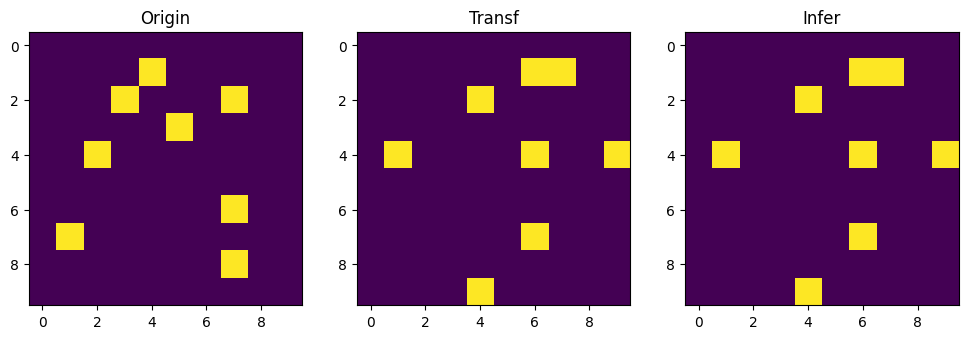

In [116]:
toy_image_id = get_random_toy_image_ids(1)[0]
toy_image = get_toy_image(toy_image_id)
toy_image_sbv = calc_toy_image_sbv(toy_image)

toy_image_transf = transform_toy_image(toy_image, TRANSF)
toy_image_transf_sbv = encode_toy_image_sbv(toy_image_transf)

activated_clusters_mask = (clusters @ toy_image_sbv) >= cluster_ones_counts
values = Counter(cluster_output_bits[activated_clusters_mask])
toy_image_sbv_out = np.zeros_like(toy_image_sbv)
# toy_image_sbv_out[list(values.keys())] = list(values.values())
# toy_image_sbv_out = np.where(toy_image_sbv_out > 1, 1, 0)
toy_image_sbv_out[list(values.keys())] = 1

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figwidth(12)
ax1.set_title('Origin')
ax1.imshow(vec_to_square_matrix(decode_toy_image_sbv(toy_image_sbv)))
ax2.set_title('Transf')
ax2.imshow(vec_to_square_matrix(decode_toy_image_sbv(toy_image_transf_sbv)))
ax3.set_title('Infer')
ax3.imshow(vec_to_square_matrix(decode_toy_image_sbv(toy_image_sbv_out)));

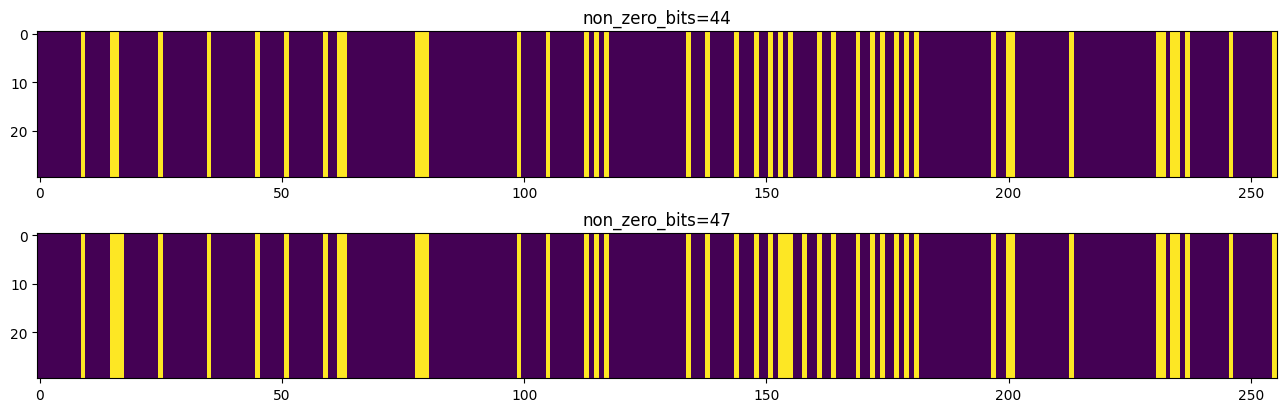

In [110]:
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.set_figwidth(16)

toy_image_transf = transform_toy_image(toy_image, TRANSF)
toy_image_transf_sbv = encode_toy_image_sbv(toy_image_transf)

ax1.set_title(f'non_zero_bits={toy_image_transf_sbv.sum()}')
ax1.imshow(np.ones((30, 1)) * toy_image_transf_sbv);
ax2.set_title(f'non_zero_bits={toy_image_sbv_out.sum()}')
ax2.imshow(np.ones((30, 1)) * toy_image_sbv_out);